# Multiple Regression Project

Please fill out:
* Student name: Max Steele
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: James Irving
* Blog post URL: 


## Table of Contents

# INTRODUCTION

# OBTAIN

In [85]:
import pandas as pd

pd.set_option('display.max_columns',0)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [86]:
## read in csv file
data = pd.read_csv('kc_house_data.csv')

## display first 5 rows of DataFrame
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.000,3,1.000,1180,5650,1.000,nan,0.000,3,7,1180,0.0,1955,0.000,98178,47.511,-122.257,1340,5650
1,6414100192,12/9/2014,538000.000,3,2.250,2570,7242,2.000,0.000,0.000,3,7,2170,400.0,1951,1991.000,98125,47.721,-122.319,1690,7639
2,5631500400,2/25/2015,180000.000,2,1.000,770,10000,1.000,0.000,0.000,3,6,770,0.0,1933,nan,98028,47.738,-122.233,2720,8062
3,2487200875,12/9/2014,604000.000,4,3.000,1960,5000,1.000,0.000,0.000,5,7,1050,910.0,1965,0.000,98136,47.521,-122.393,1360,5000
4,1954400510,2/18/2015,510000.000,3,2.000,1680,8080,1.000,0.000,0.000,3,8,1680,0.0,1987,0.000,98074,47.617,-122.045,1800,7503


In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

There are several things of note based on this initial inspection of the DataFrame. Date will likely be more useful if we can separate out the year the house was sold.  The yr_renovated column is likely to be zero-inflated as a result of houses that haven't ever been renovated. The sqft_basement column is also likely to be zero-inflated and may be easier to work with as a categorical variable. However, sqft_basement is definitely a column that should be numeric, but it is currently object data type. That will require further investigation and cleaning to ensure the data are represented accurately regardless of whether we proceed with it as a categorical or continuous variable. 

Waterfront is stored as a float, but it is a category: either the propert is on the water (1.0) or it isn't (0.0). View is also stored as a float, but it is unclear what exactly this variable means. I will likely exclude it from the model.

It might be better to treat zipcode as a categorical variable since a higher or lower zipcode doesn't really imply anything about quantity and a model won't recognize this.

Most columns do not appear to have missing values at first glance (most columns are showing up as not containing NaN values); however, I'll still need to check for placeholder values in all columns.

# SCRUB

In [88]:
## display the number and percent of NaN's in each column
missing_values = pd.DataFrame()
missing_values['Number of Nulls'] = data.isna().sum()
missing_values['% Null'] = (data.isna().sum() / len(data)) * 100
missing_values

,Number of Nulls,% Null
id,0,0.000
date,0,0.000
price,0,0.000
bedrooms,0,0.000
bathrooms,0,0.000
sqft_living,0,0.000
sqft_lot,0,0.000
floors,0,0.000
waterfront,2376,11.002
view,63,0.292


> -  Only 0.29% of the view column is missing.
- 11% of the waterfront column is missing.
- 17.8% of the yr_renovated column is missing.

In [89]:
## get summary statistics of the numeric columns
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,19221.000,21534.000,21597.000,21597.000,21597.000,21597.000,17755.000,21597.000,21597.000,21597.000,21597.000,21597.000
mean,4580474287.771,540296.574,3.373,2.116,2080.322,15099.409,1.494,0.008,0.234,3.410,7.658,1788.597,1971.000,83.637,98077.952,47.560,-122.214,1986.620,12758.284
std,2876735715.748,367368.140,0.926,0.769,918.106,41412.637,0.540,0.087,0.766,0.651,1.173,827.760,29.375,399.946,53.513,0.139,0.141,685.230,27274.442
min,1000102.000,78000.000,1.000,0.500,370.000,520.000,1.000,0.000,0.000,1.000,3.000,370.000,1900.000,0.000,98001.000,47.156,-122.519,399.000,651.000
25%,2123049175.000,322000.000,3.000,1.750,1430.000,5040.000,1.000,0.000,0.000,3.000,7.000,1190.000,1951.000,0.000,98033.000,47.471,-122.328,1490.000,5100.000
50%,3904930410.000,450000.000,3.000,2.250,1910.000,7618.000,1.500,0.000,0.000,3.000,7.000,1560.000,1975.000,0.000,98065.000,47.572,-122.231,1840.000,7620.000
75%,7308900490.000,645000.000,4.000,2.500,2550.000,10685.000,2.000,0.000,0.000,4.000,8.000,2210.000,1997.000,0.000,98118.000,47.678,-122.125,2360.000,10083.000
max,9900000190.000,7700000.000,33.000,8.000,13540.000,1651359.000,3.500,1.000,4.000,5.000,13.000,9410.000,2015.000,2015.000,98199.000,47.778,-121.315,6210.000,871200.000


In [90]:
## print out the counts of unique values appearing in each column, including counts of NaN
for col in data.columns:
    print(col, '\n', data[col].value_counts(dropna=False), '\n\n')

id 
 795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
             ..
7812801125    1
4364700875    1
3021059276    1
880000205     1
1777500160    1
Name: id, Length: 21420, dtype: int64 


date 
 6/23/2014    142
6/26/2014    131
6/25/2014    131
7/8/2014     127
4/27/2015    126
            ... 
5/27/2015      1
8/30/2014      1
5/24/2015      1
11/2/2014      1
3/8/2015       1
Name: date, Length: 372, dtype: int64 


price 
 350000.000    172
450000.000    172
550000.000    159
500000.000    152
425000.000    150
             ... 
870515.000      1
336950.000      1
386100.000      1
176250.000      1
884744.000      1
Name: price, Length: 3622, dtype: int64 


bedrooms 
 3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64 


bathrooms 
 2.500    5377
1.000    3851
1.750    3048
2.250    2047
2.000    1930
1.500    1445
2.750    1185
3.000    

> - The sqft_basement column has a placeholder value of '?'. This represents 2.1% of the column (454 / 21597).
- Several columns appear to be zero-inflated:
 - waterfront
 - view
 - sqft_basement
 - yr_renovated
> - The meaning behind the view column is unclear, so I have decided to drop the column entirely.


In [91]:
## drop view column from dataframe
data.drop(columns='view', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   17755 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

In [92]:
## check for any identical rows in the dataset
data.duplicated().sum()

0

> - None of the rows are exact duplicates, but there are some houses that were sold more than once during this time period. This is made evident by the fact that some house id numbers appear multiple times (value counts). This will require some further investigation as this technically violates the assumption of independence among observations.

## Create Additional Columns

In [93]:
from pandas.api.types import is_numeric_dtype

def check_col(column):
    print('*** {} ***'.format(column.name))
    print('---------------')
    print('Data Type: {}'.format(column.dtype))
    print('% Null: {}'.format((column.isna().sum()/len(column)) * 100))
    print('---------------')
    print('Value Counts:\n {}'.format(column.value_counts(dropna=False)))
    print('---------------')
    if is_numeric_dtype(column):
          print('Min: {}\nMax:{}'.format(column.min(), column.max()))

In [94]:
## from date column, create a year sold column
data['yr_sold'] = data['date'].apply(lambda x: x.split('/')[-1]).astype('int64')
check_col(data['yr_sold'])

*** yr_sold ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 2014    14622
2015     6975
Name: yr_sold, dtype: int64
---------------
Min: 2014
Max:2015


In [95]:
## from date column, create a month sold column
data['month_sold'] = data['date'].apply(lambda x: x.split('/')[0]).astype('int64')
check_col(data['month_sold'])

*** month_sold ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 5     2414
4     2229
7     2211
6     2178
8     1939
10    1876
3     1875
9     1771
12    1470
11    1409
2     1247
1      978
Name: month_sold, dtype: int64
---------------
Min: 1
Max:12


In [96]:
## create a season column based on month sold
def season(month):
    """Assign a season based on month according to Northern meteorological definition."""
    if month in [3,4,5]:
        return 'spring'
    elif month in [6,7,8]:
        return 'summer'
    elif month in [9,10,11]:
        return 'fall'
    else:
        return 'winter'

data['season_sold'] = data['month_sold'].apply(season)
check_col(data['season_sold'])

*** season_sold ***
---------------
Data Type: object
% Null: 0.0
---------------
Value Counts:
 spring    6518
summer    6328
fall      5056
winter    3695
Name: season_sold, dtype: int64
---------------


In [97]:
## create a column that represents the age of the house when it was sold
data['age'] = data['yr_sold'] - data['yr_built']
check_col(data['age'])

*** age ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
  9      472
 8      443
 11     431
 0      430
 10     428
       ... 
 113     28
 115     26
 81      23
 80      21
-1       12
Name: age, Length: 117, dtype: int64
---------------
Min: -1
Max:115


In [98]:
## it appears 12 houses were sold before they were finished being built
## this is pretty much the same as being sold at 0 years old (brand new), and homeowners selling their
##   homes won't have homes that are less than 0 years old, so replace -1 with 0 for these 12 homes
data['age'].replace({-1: 0}, inplace=True)
check_col(data['age'])

*** age ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 9      472
8      443
0      442
11     431
10     428
      ... 
112     33
113     28
115     26
81      23
80      21
Name: age, Length: 116, dtype: int64
---------------
Min: 0
Max:115


In [99]:
## create a column that represents the difference between the square footage of living area of a house 
##  and the average of its 15 nearest neighbors
data['diff_sqft_living15'] = data['sqft_living'] - data['sqft_living15']
check_col(data['diff_sqft_living15'])

*** diff_sqft_living15 ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
  0       2563
-10       240
-40       202
-50       196
 50       191
         ... 
 358        1
-362        1
 92         1
 2125       1
 4030       1
Name: diff_sqft_living15, Length: 1018, dtype: int64
---------------
Min: -2310
Max:8690


In [100]:
## create a column that represents the difference between the square footage of the lot area of a house 
##  and the average of its 15 nearest neighbors
data['diff_sqft_lot15'] = data['sqft_lot'] - data['sqft_lot15']
check_col(data['diff_sqft_lot15'])

*** diff_sqft_lot15 ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
  0        4474
-1          62
-600        54
 1000       53
-200        50
          ... 
-11101       1
-2166        1
 37740       1
 4948        1
 43560       1
Name: diff_sqft_lot15, Length: 7159, dtype: int64
---------------
Min: -326879
Max:1225778


## Drop Duplicate Houses

In [102]:
## create a df that displays house id's that were sold more than once
id_counts = pd.DataFrame(data['id'].value_counts().
                         rename_axis('unique_values').
                         reset_index(name='counts'))
dup_ids = id_counts.loc[id_counts['counts']>1] 
dup_ids

,unique_values,counts
0,795000620,3
1,1825069031,2
2,2019200220,2
3,7129304540,2
4,1781500435,2
...,...,...
171,7893805650,2
172,8161020060,2
173,1432400120,2
174,7701960990,2


> - It appears 176 houses were sold more than once during this time frame (May 2014 - May 2015).

In [103]:
## display rows for the one house that sold 3 times
data.loc[data['id']==795000620]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold,season_sold,age,diff_sqft_living15,diff_sqft_lot15,adj_grade
17588,795000620,9/24/2014,115000.000,3,1.000,1080,6250,1.000,0.000,2,5,1080,0.0,1950,0.000,98168,47.505,-122.330,1070,6250,2014,9,fall,64,10,0,0.487
17589,795000620,12/15/2014,124000.000,3,1.000,1080,6250,1.000,0.000,2,5,1080,0.0,1950,0.000,98168,47.505,-122.330,1070,6250,2014,12,winter,64,10,0,0.487
17590,795000620,3/11/2015,157000.000,3,1.000,1080,6250,1.000,nan,2,5,1080,0.0,1950,nan,98168,47.505,-122.330,1070,6250,2015,3,spring,65,10,0,0.487


In [104]:
## create a list of id's for houses that sold more than once
dup_houses = list(dup_ids['unique_values'])

## create a df containing all records of houses sold more than once
dup_houses_df = data.loc[data['id'].isin(dup_houses)]
## sort the df by house id and then by year and month sold so records for each house id appear together
  # and in chronological order
dup_houses_df = dup_houses_df.sort_values(by=['id', 'yr_sold', 'month_sold'], axis=0)

print(dup_houses_df.info())

dup_houses_df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353 entries, 2494 to 1085
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  353 non-null    int64  
 1   date                353 non-null    object 
 2   price               353 non-null    float64
 3   bedrooms            353 non-null    int64  
 4   bathrooms           353 non-null    float64
 5   sqft_living         353 non-null    int64  
 6   sqft_lot            353 non-null    int64  
 7   floors              353 non-null    float64
 8   waterfront          307 non-null    float64
 9   condition           353 non-null    int64  
 10  grade               353 non-null    int64  
 11  sqft_above          353 non-null    int64  
 12  sqft_basement       353 non-null    object 
 13  yr_built            353 non-null    int64  
 14  yr_renovated        286 non-null    float64
 15  zipcode             353 non-null    int64  
 16  lat 

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold,season_sold,age,diff_sqft_living15,diff_sqft_lot15,adj_grade
2494,1000102,9/16/2014,280000.000,6,3.000,2400,9373,2.000,nan,3,7,2400,0.0,1991,0.000,98002,47.326,-122.214,2060,7316,2014,9,fall,23,340,2057,0.523
2495,1000102,4/22/2015,300000.000,6,3.000,2400,9373,2.000,0.000,3,7,2400,0.0,1991,0.000,98002,47.326,-122.214,2060,7316,2015,4,spring,24,340,2057,0.523
16800,7200179,10/16/2014,150000.000,2,1.000,840,12750,1.000,0.000,3,6,840,0.0,1925,0.000,98055,47.484,-122.211,1480,6969,2014,10,fall,89,-640,5781,0.636
16801,7200179,4/24/2015,175000.000,2,1.000,840,12750,1.000,0.000,3,6,840,0.0,1925,nan,98055,47.484,-122.211,1480,6969,2015,4,spring,90,-640,5781,0.636
11421,109200390,8/20/2014,245000.000,3,1.750,1480,3900,1.000,0.000,4,7,1480,0.0,1980,0.000,98023,47.298,-122.367,1830,6956,2014,8,summer,34,-350,-3056,0.614
11422,109200390,10/20/2014,250000.000,3,1.750,1480,3900,1.000,0.000,4,7,1480,0.0,1980,0.000,98023,47.298,-122.367,1830,6956,2014,10,fall,34,-350,-3056,0.614
12405,123039336,6/11/2014,148000.000,1,1.000,620,8261,1.000,0.000,3,5,620,0.0,1939,0.000,98106,47.514,-122.364,1180,8244,2014,6,summer,75,-560,17,0.586
12406,123039336,12/8/2014,244900.000,1,1.000,620,8261,1.000,0.000,3,5,620,0.0,1939,nan,98106,47.514,-122.364,1180,8244,2014,12,winter,75,-560,17,0.586
7785,251300110,7/31/2014,225000.000,3,2.250,2510,12013,2.000,0.000,3,8,2510,0.0,1988,0.000,98003,47.347,-122.314,1870,8017,2014,7,summer,26,640,3996,0.589
7786,251300110,1/14/2015,358000.000,3,2.250,2510,12013,2.000,0.000,3,8,2510,0.0,1988,0.000,98003,47.347,-122.314,1870,8017,2015,1,winter,27,640,3996,0.589


> - There are opportunities to fill in null or missing values for these duplicate houses based on the other record for the house.

In [105]:
## create a df of duplicate houses that have at least one null or otherwise missing value
null_dups = dup_houses_df.loc[dup_houses_df['waterfront'].isna() |
                  dup_houses_df['yr_renovated'].isna() |
                  (dup_houses_df['waterfront']=='?')]
null_dups

/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold,season_sold,age,diff_sqft_living15,diff_sqft_lot15,adj_grade
2494,1000102,9/16/2014,280000.000,6,3.000,2400,9373,2.000,nan,3,7,2400,0.0,1991,0.000,98002,47.326,-122.214,2060,7316,2014,9,fall,23,340,2057,0.523
16801,7200179,4/24/2015,175000.000,2,1.000,840,12750,1.000,0.000,3,6,840,0.0,1925,nan,98055,47.484,-122.211,1480,6969,2015,4,spring,90,-640,5781,0.636
12406,123039336,12/8/2014,244900.000,1,1.000,620,8261,1.000,0.000,3,5,620,0.0,1939,nan,98106,47.514,-122.364,1180,8244,2014,12,winter,75,-560,17,0.586
14841,324000530,7/8/2014,201500.000,3,1.000,1320,5000,1.500,0.000,3,7,1320,0.0,1912,nan,98116,47.571,-122.386,1320,4179,2014,7,summer,102,0,821,0.638
824,726049190,2/18/2015,431000.000,3,1.000,1810,7200,1.000,nan,4,7,1130,680.0,1954,0.000,98133,47.749,-122.351,1810,8100,2015,2,winter,61,0,-900,0.574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2974,9136103130,12/1/2014,430000.000,2,1.500,1090,4013,1.500,nan,3,7,1090,0.0,1900,0.000,98103,47.665,-122.338,1390,4013,2014,12,winter,114,-300,0,0.680
2975,9136103130,5/12/2015,685000.000,2,1.500,1090,4013,1.500,0.000,3,7,1090,0.0,1900,nan,98103,47.665,-122.338,1390,4013,2015,5,spring,115,-300,0,0.680
6365,9222400605,11/15/2014,842500.000,5,4.000,2980,4500,1.500,nan,3,7,2070,910.0,1921,0.000,98115,47.674,-122.323,1560,4225,2014,11,fall,93,1420,275,0.486
16658,9250900104,4/10/2015,496000.000,5,1.750,2110,8500,1.000,0.000,3,7,1100,1010.0,1962,nan,98133,47.774,-122.350,2020,8500,2015,4,spring,53,90,0,0.546


In [106]:
null_dups['id'].value_counts()

3262300940    2
2892700041    2
4345000510    2
2212200100    2
1954420170    2
             ..
7524400250    1
1901600090    1
2019200220    1
2767602141    1
4435000705    1
Name: id, Length: 91, dtype: int64

> - Of the houses that sold more than once, 91 of them have null or otherwise missing values.

In [107]:
## sqft_basement uses a placeholder value
## check value counts to see how many records need to be fixed
null_dups['sqft_basement'].value_counts()

0.0       74
310.0      4
250.0      3
910.0      3
980.0      2
700.0      2
500.0      2
200.0      1
730.0      1
850.0      1
1200.0     1
1080.0     1
300.0      1
920.0      1
750.0      1
280.0      1
?          1
680.0      1
570.0      1
1010.0     1
430.0      1
350.0      1
10.0       1
990.0      1
1380.0     1
900.0      1
1000.0     1
Name: sqft_basement, dtype: int64

In [108]:
## find the one record missing the sqft_basement value in the null_dups df
null_dups.loc[null_dups['sqft_basement']=='?']

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold,season_sold,age,diff_sqft_living15,diff_sqft_lot15,adj_grade
19321,6021500970,4/7/2015,874950.000,2,1.000,1080,4000,1.000,0.000,3,7,1080,?,1940,nan,98117,47.690,-122.387,1530,4240,2015,4,spring,75,-450,-240,0.682


In [109]:
## find the records of that house in the full dup_houses_df
dup_houses_df.loc[dup_houses_df['id']==(list(null_dups.loc[null_dups['sqft_basement']=='?']['id'])[0])]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold,season_sold,age,diff_sqft_living15,diff_sqft_lot15,adj_grade
19320,6021500970,5/28/2014,345000.000,2,1.000,1080,4000,1.000,0.000,3,7,1080,0.0,1940,0.000,98117,47.690,-122.387,1530,4240,2014,5,spring,74,-450,-240,0.682
19321,6021500970,4/7/2015,874950.000,2,1.000,1080,4000,1.000,0.000,3,7,1080,?,1940,nan,98117,47.690,-122.387,1530,4240,2015,4,spring,75,-450,-240,0.682


In [110]:
## the house in question has 0 sqft_basement, so fix the record that is missing this info
## IN THE ORIGINAL DATAFRAME
data.loc[19321, 'sqft_basement'] = 0
data.loc[19321]

id                    6021500970
date                    4/7/2015
price                 874950.000
bedrooms                       2
bathrooms                  1.000
sqft_living                 1080
sqft_lot                    4000
floors                     1.000
waterfront                 0.000
condition                      3
grade                          7
sqft_above                  1080
sqft_basement                  0
yr_built                    1940
yr_renovated                 NaN
zipcode                    98117
lat                       47.690
long                    -122.387
sqft_living15               1530
sqft_lot15                  4240
yr_sold                     2015
month_sold                     4
season_sold               spring
age                           75
diff_sqft_living15          -450
diff_sqft_lot15             -240
adj_grade                  0.682
Name: 19321, dtype: object

In [111]:
## group houses by id and find the mean for each id
## most house id's will contain the same information (value / 1 = mean) because 
  ## most houses were only sold once
## if a house was sold twice and has a single null value in its record, the mean will show up as the value in 
  # the other record for the house and this can be used to replace the null value
## the values that we're replacing (waterfront and yr_renovated) are not extremely likely to have changed 
  # in the course of a year
mean_dup_houses = data.groupby('id').mean()
mean_dup_houses

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold,age,diff_sqft_living15,diff_sqft_lot15,adj_grade
id,,,,,,,,,,,,,,,,,,,,,,,
1000102,290000.000,6.000,3.000,2400.000,9373.000,2.000,0.000,3.000,7.000,2400.000,1991.000,0.000,98002.000,47.326,-122.214,2060.000,7316.000,2014.500,6.500,23.500,340.000,2057.000,0.523
1200019,647500.000,4.000,1.750,2060.000,26036.000,1.000,nan,4.000,8.000,1160.000,1947.000,0.000,98166.000,47.444,-122.351,2590.000,21891.000,2014.000,5.000,67.000,-530.000,4145.000,0.629
1200021,400000.000,3.000,1.000,1460.000,43000.000,1.000,0.000,3.000,7.000,1460.000,1952.000,0.000,98166.000,47.443,-122.347,2250.000,20023.000,2014.000,8.000,62.000,-790.000,22977.000,0.617
2800031,235000.000,3.000,1.000,1430.000,7599.000,1.500,0.000,4.000,6.000,1010.000,1930.000,0.000,98168.000,47.478,-122.265,1290.000,10320.000,2015.000,4.000,85.000,140.000,-2721.000,0.533
3600057,402500.000,4.000,2.000,1650.000,3504.000,1.000,0.000,3.000,7.000,760.000,1951.000,2013.000,98144.000,47.580,-122.294,1480.000,3504.000,2015.000,3.000,64.000,170.000,0.000,0.592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9842300095,365000.000,5.000,2.000,1600.000,4168.000,1.500,0.000,3.000,7.000,1600.000,1927.000,0.000,98126.000,47.530,-122.381,1190.000,4168.000,2014.000,7.000,87.000,410.000,0.000,0.598
9842300485,380000.000,2.000,1.000,1040.000,7372.000,1.000,0.000,5.000,7.000,840.000,1939.000,0.000,98126.000,47.529,-122.378,1930.000,5150.000,2015.000,3.000,76.000,-890.000,2222.000,0.691
9842300540,339000.000,3.000,1.000,1100.000,4128.000,1.000,0.000,4.000,7.000,720.000,1942.000,nan,98126.000,47.530,-122.379,1510.000,4538.000,2014.000,6.000,72.000,-410.000,-410.000,0.678


In [112]:
## create a list of id's for houses that sold more than once that had a null value for waterfront
null_dups_waterfront = dup_houses_df.loc[dup_houses_df['waterfront'].isna()]
null_dups_waterfront_list = list(null_dups_waterfront['id'])

## create a list of id's for houses that sold more than once that had a null value for yr_renovated
null_dups_renov = dup_houses_df.loc[dup_houses_df['yr_renovated'].isna()]
null_dups_renov_list = list(null_dups_renov['id'])

In [113]:
## for each id in the list of duplicate houses with null values,
## replace values with the mean for waterfront
for house_id in null_dups_waterfront_list:
    data.loc[data['id']==house_id, 'waterfront'] = mean_dup_houses.loc[house_id, 'waterfront']
check_col(data['waterfront'])

*** waterfront ***
---------------
Data Type: float64
% Null: 10.816317081076075
---------------
Value Counts:
 0.000    19115
nan       2336
1.000      146
Name: waterfront, dtype: int64
---------------
Min: 0.0
Max:1.0


In [114]:
## for each id in the list of duplicate houses with null values,
## replace values with the mean for yr_renovated
for house_id in null_dups_renov_list:
    data.loc[data['id']==house_id, 'yr_renovated'] = mean_dup_houses.loc[house_id, 'yr_renovated']
check_col(data['yr_renovated'])

*** yr_renovated ***
---------------
Data Type: float64
% Null: 17.525582256794927
---------------
Value Counts:
 0.000       17068
nan          3785
2014.000       73
2003.000       31
2013.000       31
            ...  
1944.000        1
1948.000        1
1976.000        1
1934.000        1
1953.000        1
Name: yr_renovated, Length: 71, dtype: int64
---------------
Min: 0.0
Max:2015.0


In [115]:
len(data)

21597

In [116]:
## only want to keep the most recent entry for each house that was sold more than once in the final df
## if this works it should drop 177 rows, so 21597 - 177 = 21420
len(data.sort_values(by=['id', 'yr_sold', 'month_sold'], axis=0).drop_duplicates(subset='id', keep='last'))

21420

In [117]:
## sort the rows first by id to group any duplicates, then by year sold, then month to put the 
 ## duplicate sellers in chronological order so that we can drop all bu the last record for each id
data = data.sort_values(by=['id', 'yr_sold', 'month_sold'], axis=0).drop_duplicates(subset='id', keep='last')

## check that each house id now only shows up once
data['id'].value_counts()

2911700010    1
8732800090    1
1545808560    1
2078500210    1
1562000050    1
             ..
1189000492    1
1023059246    1
7202340820    1
4039300400    1
1777500160    1
Name: id, Length: 21420, dtype: int64

In [118]:
## resort the df so it's back in the original order
data.sort_index(inplace=True)
data.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            21587, 21588, 21589, 21590, 21591, 21592, 21593, 21594, 21595,
            21596],
           dtype='int64', length=21420)

## QUESTION 1: Which variables should be treated as continuous versus categorical?

I have already noted several columns that may need to be cast as different data types and treated as categorical/ binned for modelling purposes. In the following section I will examine each column individually to determine what sort of variable the column best represents. This will involve examining value counts, the amount of null and otherwise missing values (placeholders) within the column, the number of unique values, etc. As such, I will be recasting columns and dealing with null/missing values for each column in this section.

As a first step, I will examine histograms for all variables as they currently stand.

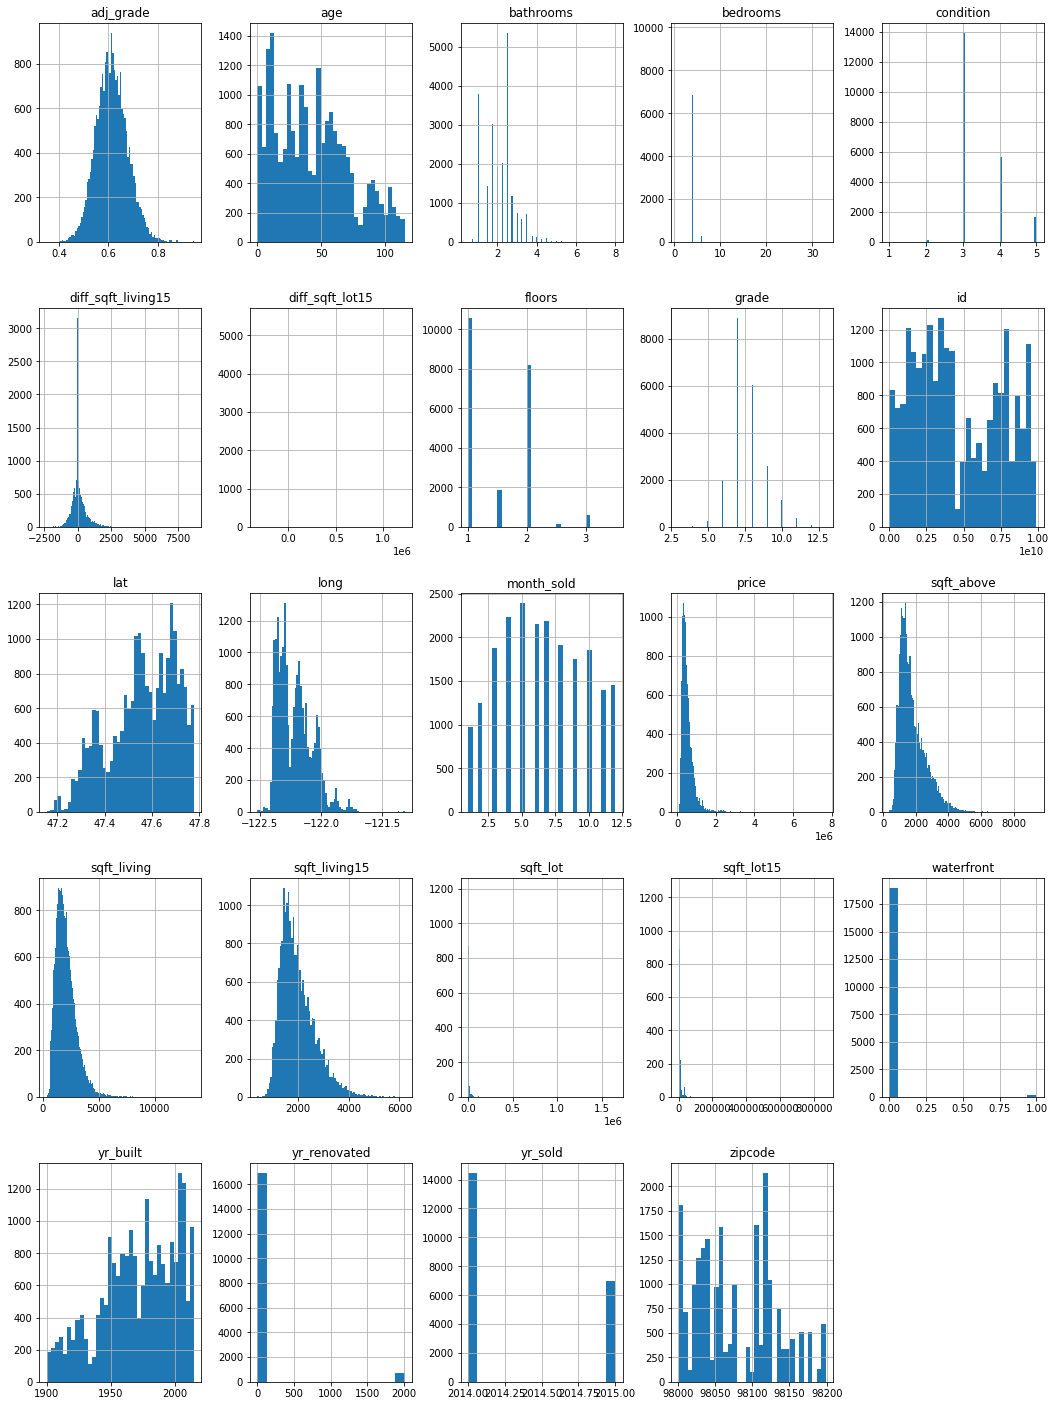

In [119]:
data.hist(figsize=(18, 25), bins='auto');

None of the variables look very normally distributed. Variables like price (the target variable), sqft_above, sqft_living, sqft_living15, and age/yr_built may need to be transformed in some way to be easier to work with. A log transformation may work well for most of those since they are mostly right skewed.

The variables will need to be standardized so that they have similar scales because they currently vary widely in magnitude.

There are definitely variables with outliers that require further investigation. The bedroom and price columns need to be checked, as well as basically all the columns dealing with square footage.

### Target Variable: Price

> - The target variable, price, is very non-normally distributed and definitely contains outliers that will likely need to be removed.

In [120]:
check_col(data['price'])

*** price ***
---------------
Data Type: float64
% Null: 0.0
---------------
Value Counts:
 450000.000    172
350000.000    167
550000.000    157
500000.000    151
425000.000    149
             ... 
234975.000      1
804995.000      1
870515.000      1
336950.000      1
884744.000      1
Name: price, Length: 3595, dtype: int64
---------------
Min: 78000.0
Max:7700000.0


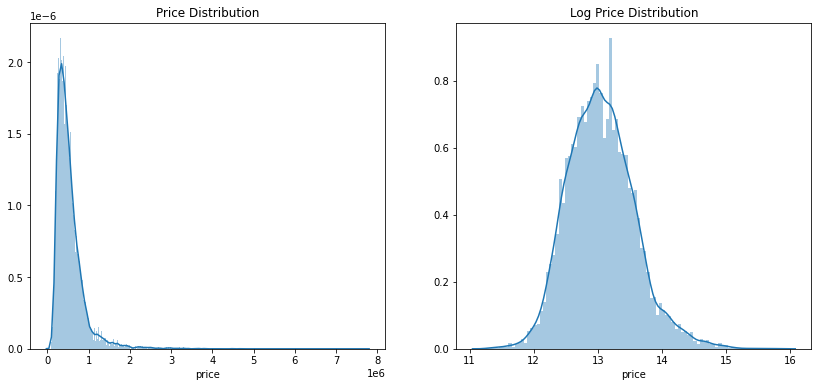

In [121]:
fig, axes = plt.subplots(ncols=2, figsize=(14,6))
ax1 = axes[0]
ax2 = axes[1]
sns.distplot(data['price'], bins='auto', ax=ax1)
sns.distplot(np.log(data['price']), bins='auto', ax=ax2)
ax1.set_title('Price Distribution')
ax2.set_title('Log Price Distribution');

<AxesSubplot:xlabel='price'>

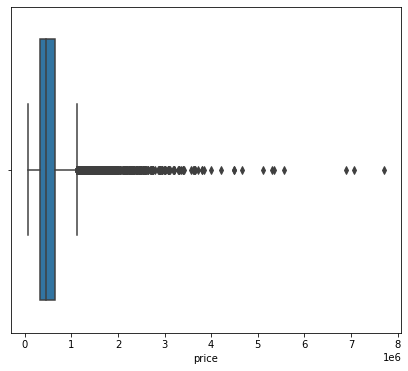

In [122]:
plt.figure(figsize=(7,6))
sns.boxplot(data['price'])

### Age / yr_built

> - These two columns hold essentially the same information. I will use age in my models since this metric is something a homeowner can easily figure out for their own home, whereas if I reported on the year the house was built, they may not take into account that the houses in this dataset were all sold 5-6 years ago. If necessary, I can use a log transformation to adjust for some of the right skewedness of the data. However, I will need to add a constant (age + 1) because some houses were 0 years old when sold and the log of 0 is undefined.

In [123]:
check_col(data['yr_built'])

*** yr_built ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 2014    559
2006    453
2005    450
2004    429
2003    420
       ... 
1901     29
1933     29
1902     27
1935     24
1934     21
Name: yr_built, Length: 116, dtype: int64
---------------
Min: 1900
Max:2015


In [124]:
check_col(data['age'])

*** age ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 9      472
8      443
0      442
11     431
10     424
      ... 
112     33
113     28
115     26
81      22
80      21
Name: age, Length: 116, dtype: int64
---------------
Min: 0
Max:115


> - There may be a very slight trend of decreasing price with increasing age. However it's difficult to tell whether this will become more or less pronounced with the removal of outliers.
- Age can clearly be treated as a continuous variable.

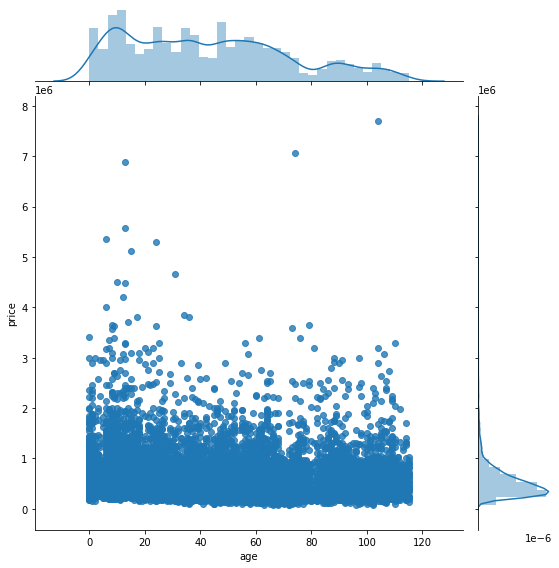

In [125]:
sns.jointplot(x='age', y='price', data=data, kind='reg', height=8);

### Bathrooms

*** bathrooms ***
---------------
Data Type: float64
% Null: 0.0
---------------
Value Counts:
 2.500    5352
1.000    3794
1.750    3020
2.250    2031
2.000    1913
1.500    1429
2.750    1182
3.000     747
3.500     729
3.250     586
3.750     155
4.000     134
4.500      99
4.250      79
0.750      70
4.750      23
5.000      21
5.250      13
5.500      10
1.250       9
6.000       6
5.750       4
0.500       4
8.000       2
6.250       2
6.750       2
6.500       2
7.500       1
7.750       1
Name: bathrooms, dtype: int64
---------------
Min: 0.5
Max:8.0
None


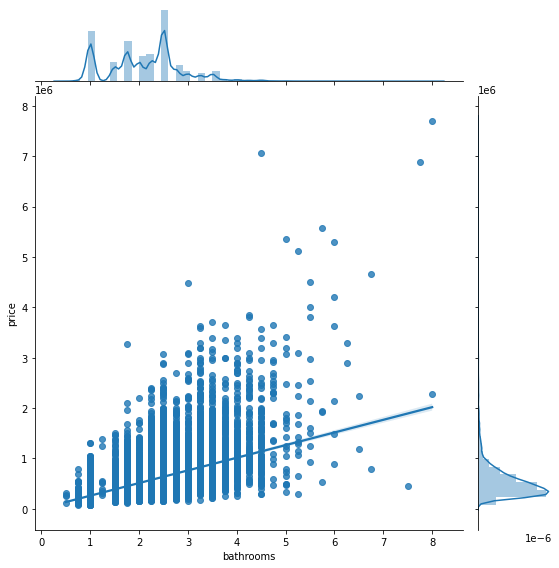

In [126]:
print(check_col(data['bathrooms']))
sns.jointplot(x='bathrooms', y='price', data=data, kind='reg', height=8);

> - There appears to be at least a slightly linear relationship between price and number of bathrooms; however there also appear to be outliers that will need to be removed and this may affect the strength of the relationship.
- Number of bathrooms should be treated as an ordinal categorical variable.

### Bedrooms

*** bedrooms ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 3     9731
4     6849
2     2736
5     1586
6      265
1      191
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64
---------------
Min: 1
Max:33
None


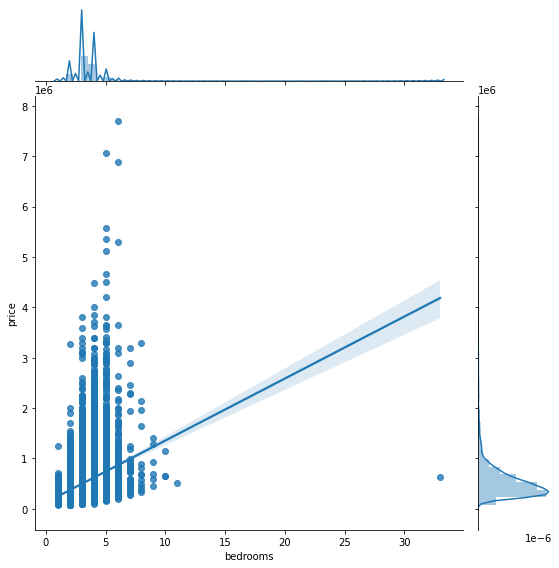

In [127]:
print(check_col(data['bedrooms']))
sns.jointplot(x='bedrooms', y='price', data=data, kind='reg', height=8);

> - There is one extreme outlier for number of bedrooms, 33. It appears this entry may be a typo. The median and mode number of bedrooms for a house in this dataset is 3, and this particular house is not very large (300 sq ft less than the median of 1920 sq ft). As such, I am replacing this value of 33 with 3.

In [128]:
display(data.loc[data['bedrooms']==33])
data.describe()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold,season_sold,age,diff_sqft_living15,diff_sqft_lot15,adj_grade
15856,2402100895,6/25/2014,640000.000,33,1.750,1620,6000,1.000,0.000,5,7,1040,580.0,1947,0.000,98103,47.688,-122.331,1330,4700,2014,6,summer,67,290,1300,0.596


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold,age,diff_sqft_living15,diff_sqft_lot15,adj_grade
count,21420.000,21420.000,21420.000,21420.000,21420.000,21420.000,21420.000,19087.000,21420.000,21420.000,21420.000,21420.000,17640.000,21420.000,21420.000,21420.000,21420.000,21420.000,21420.000,21420.000,21420.000,21420.000,21420.000,21420.000
mean,4580939869.158,541861.428,3.374,2.118,2083.133,15128.038,1.496,0.008,3.411,7.663,1791.170,1971.093,83.733,98077.874,47.560,-122.214,1988.384,12775.718,2014.325,6.564,43.233,94.749,2352.320,0.615
std,2876761172.448,367556.938,0.925,0.769,918.808,41530.797,0.540,0.087,0.650,1.172,828.693,29.387,400.176,53.477,0.139,0.141,685.537,27345.622,0.468,3.118,29.389,601.300,29022.926,0.064
min,1000102.000,78000.000,1.000,0.500,370.000,520.000,1.000,0.000,1.000,3.000,370.000,1900.000,0.000,98001.000,47.156,-122.519,399.000,651.000,2014.000,1.000,0.000,-2310.000,-326879.000,0.352
25%,2123537386.750,324950.000,3.000,1.750,1430.000,5040.000,1.000,0.000,3.000,7.000,1200.000,1952.000,0.000,98033.000,47.471,-122.328,1490.000,5100.000,2014.000,4.000,17.000,-220.000,-420.250,0.572
50%,3904921185.000,450550.000,3.000,2.250,1920.000,7614.000,1.500,0.000,3.000,7.000,1560.000,1975.000,0.000,98065.000,47.572,-122.230,1840.000,7620.000,2014.000,6.000,39.000,0.000,0.000,0.613
75%,7308900186.250,645000.000,4.000,2.500,2550.000,10690.500,2.000,0.000,4.000,8.000,2220.000,1997.000,0.000,98117.000,47.678,-122.125,2370.000,10086.250,2015.000,9.000,63.000,310.000,680.000,0.655
max,9900000190.000,7700000.000,33.000,8.000,13540.000,1651359.000,3.500,1.000,5.000,13.000,9410.000,2015.000,2015.000,98199.000,47.778,-121.315,6210.000,871200.000,2015.000,12.000,115.000,8690.000,1225778.000,0.946


*** bedrooms ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 3     9732
4     6849
2     2736
5     1586
6      265
1      191
7       38
8       13
9        6
10       3
11       1
Name: bedrooms, dtype: int64
---------------
Min: 1
Max:11
None


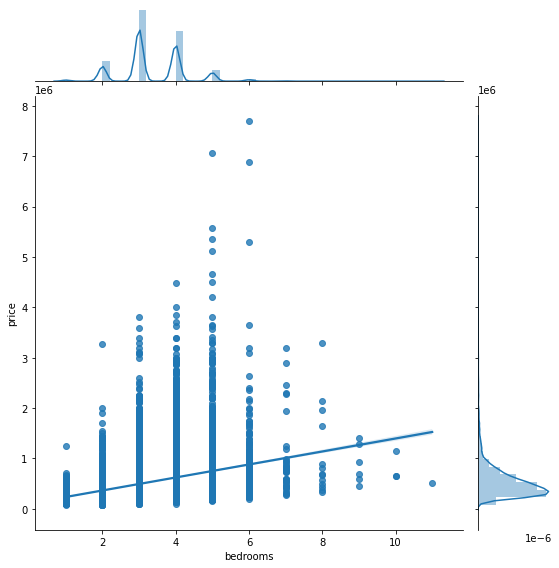

In [129]:
## replace the 33 with 3 (the median and mode for the variable 'bedrooms')
data.loc[data['bedrooms']==33, 'bedrooms'] = 3
print(check_col(data['bedrooms']))
sns.jointplot(x='bedrooms', y='price', data=data, kind='reg', height=8);
# now the maximum number of bedrooms is more reasonable at 11

> - It appears that there may be a linear relationship between price and number of bedrooms, though there may be additional outliers in terms of numbers of bedrooms that need to be removed.
- Number of bedrooms should be treated as an ordinal categorical variable.

### Floors

*** floors ***
---------------
Data Type: float64
% Null: 0.0
---------------
Value Counts:
 1.000    10552
2.000     8203
1.500     1888
3.000      609
2.500      161
3.500        7
Name: floors, dtype: int64
---------------
Min: 1.0
Max:3.5
None


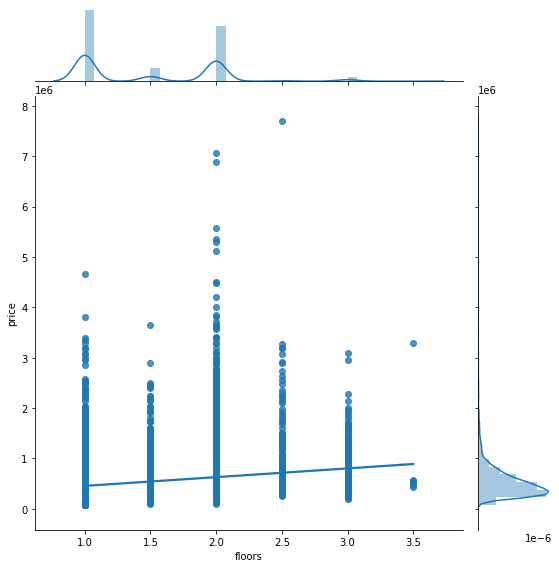

In [130]:
print(check_col(data['floors']))
sns.jointplot(x='floors', y='price', data=data, kind='reg', height=8);

> - It is not clear that there is much of a relationship between price and the number of floors in a house.
- Only 7 houses have 3.5 floors, so these might be treated as outliers. However, number of floors is also likely to be highly correlated with other variables like sqft_living area which are much more strongly related to price, so this variable may not make it into the final model.
- If floors is retained, it will be treated as an ordinal categorical variable.

### Condition

*** condition ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 3    13900
4     5643
5     1687
2      162
1       28
Name: condition, dtype: int64
---------------
Min: 1
Max:5
None


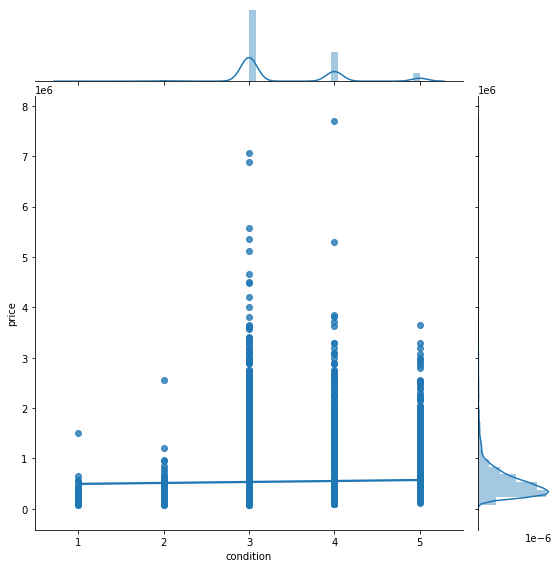

In [131]:
print(check_col(data['condition']))
sns.jointplot(x='condition', y='price', data=data, kind='reg', height=8);

> - By assigning the condition of a house a number, one might expect houses in better condition to sell for higher prices. There is no linear relationship between increasing condition and price whatsoever. 
- This is assigned by the county and is designed to be relative to grade and age (<a href="https://www.kingcounty.gov/depts/assessor/Reports/area-reports/2017/residential-westcentral/~/media/depts/assessor/documents/AreaReports/2017/Residential/013.ashx">King County Assessments</a>). Thus the relationship with price was not a straightfoward linear relationship and this variable may be best treated as a category even though the numerical ranking implies an order to the categories.

### Grade

*** grade ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 7     8889
8     6041
9     2606
6     1995
10    1130
11     396
5      234
12      88
4       27
13      13
3        1
Name: grade, dtype: int64
---------------
Min: 3
Max:13
None


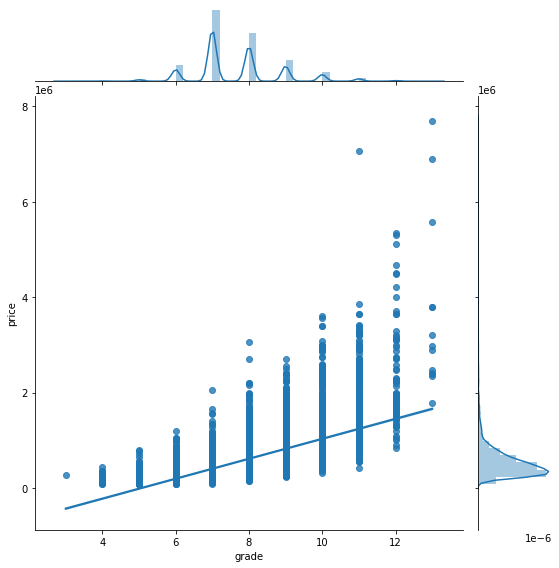

In [132]:
print(check_col(data['grade']))
sns.jointplot(x='grade', y='price', data=data, kind='reg', height=8);

> - There does appear to be a linear relationship between price and grade.
- The 'grade' variable represents a score 1 - 13 assigned by the county to each home. Thus metric takes into account the design, construction quality, and workmanship of the house (<a href="https://www.kingcounty.gov/depts/assessor/Reports/area-reports/2017/residential-westcentral/~/media/depts/assessor/documents/AreaReports/2017/Residential/013.ashx">King County Assessments</a>). However it also awards higher grades for houses with more square footage. Thus this variable is highly correlated with sqft_living (see Section 4.4).
- This variable is best treated as an ordinal categorical variable.

### Month_sold

*** month_sold ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 5     2393
4     2229
7     2187
6     2151
8     1913
3     1875
10    1854
9     1747
12    1458
11    1396
2     1244
1      973
Name: month_sold, dtype: int64
---------------
Min: 1
Max:12
None


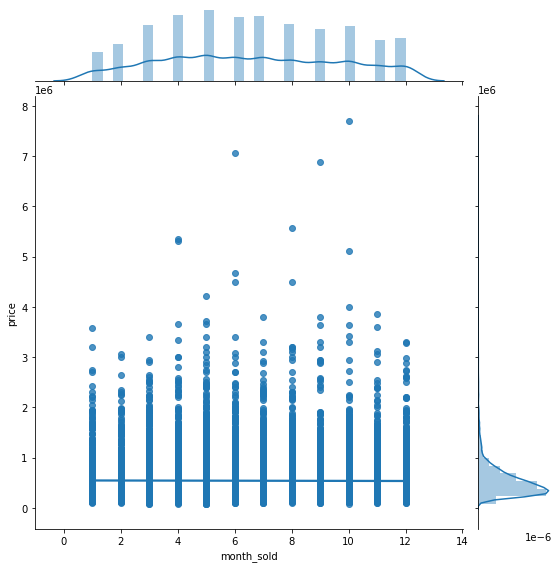

In [134]:
print(check_col(data['month_sold']))
sns.jointplot(x='month_sold', y='price', data=data, kind='reg', height=8);

> - Month sold does not appear to affect house price.

### Season_sold

*** season_sold ***
---------------
Data Type: object
% Null: 0.0
---------------
Value Counts:
 spring    6497
summer    6251
fall      4997
winter    3675
Name: season_sold, dtype: int64
---------------
None


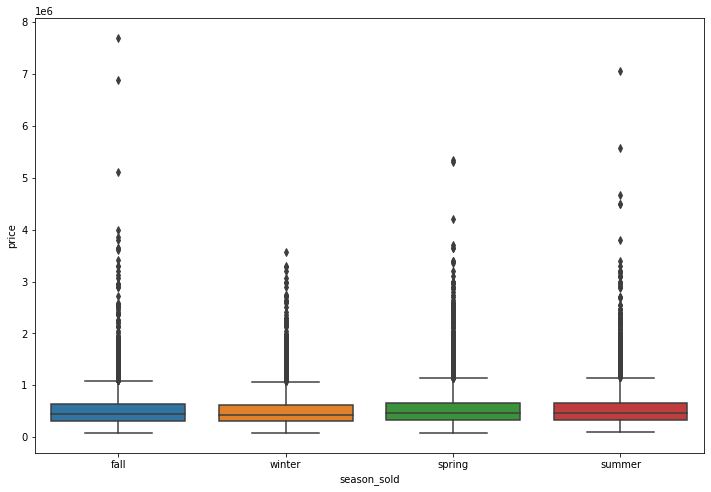

In [135]:
print(check_col(data['season_sold']))
plt.figure(figsize=(12,8))
sns.boxplot(x='season_sold', y='price', data=data);

> - There appears to be no affect of season on selling price whatsoever.

### Yr_sold

*** yr_sold ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 2014    14453
2015     6967
Name: yr_sold, dtype: int64
---------------
Min: 2014
Max:2015
None


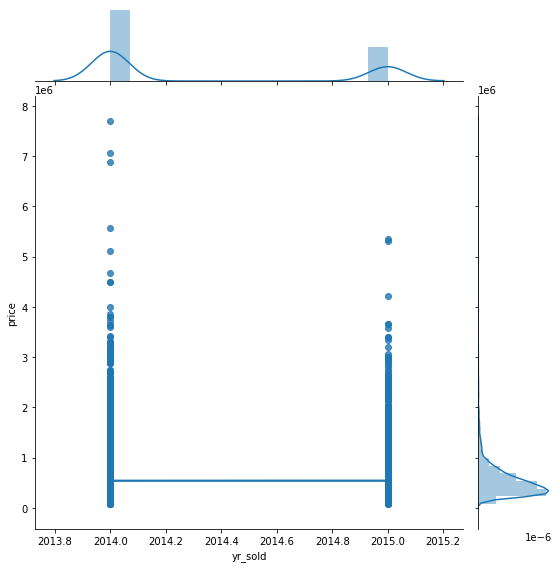

In [136]:
print(check_col(data['yr_sold']))
sns.jointplot(x='yr_sold', y='price', data=data, kind='reg', height=8);

> - There is no relationship between year sold and price.

### Sqft_above

*** sqft_above ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 1300    210
1010    204
1200    203
1220    186
1140    183
       ... 
2665      1
2601      1
440       1
2473      1
1975      1
Name: sqft_above, Length: 942, dtype: int64
---------------
Min: 370
Max:9410
None


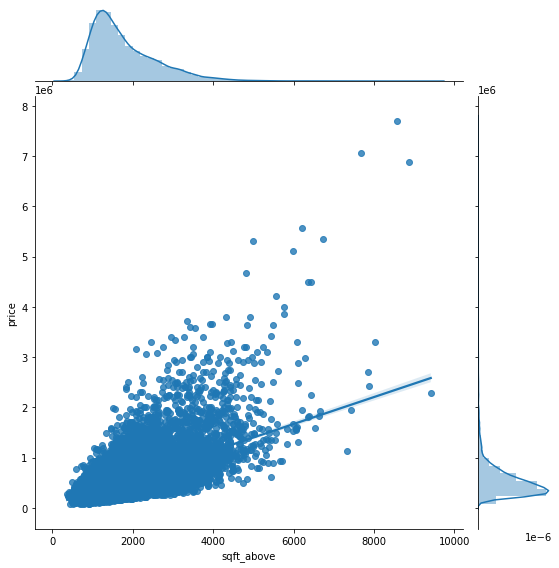

In [137]:
print(check_col(data['sqft_above']))
sns.jointplot(x='sqft_above', y='price', data=data, kind='reg', height=8);

> - There appears to be a relatively linear relationship between price and square foot above ground, but there are also outliers that need to be removed.
- Sqft_above should definitely be treated as a continuous variable.

### Sqft_basement

In [138]:
check_col(data['sqft_basement'])

*** sqft_basement ***
---------------
Data Type: object
% Null: 0.0
---------------
Value Counts:
 0.0       12716
?           451
600.0       216
700.0       206
500.0       206
          ...  
1245.0        1
946.0         1
2850.0        1
1008.0        1
0             1
Name: sqft_basement, Length: 305, dtype: int64
---------------


In [139]:
(len(data.loc[data['sqft_basement']=='?']) / len(data)) * 100

2.1055088702147526

This column has a placeholder value of '?' which makes up 2.1% of the column. There are 451 records with this placeholder value.

In [140]:
## estimate the square footage of basements for all houses by subtracting sqft_above from sqft_living
data['est_sqft_basement'] = data['sqft_living'] - data['sqft_above']
check_col(data['est_sqft_basement'])

*** est_sqft_basement ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 0       12999
600       220
700       215
500       211
800       206
        ...  
1816        1
792         1
2590        1
935         1
248         1
Name: est_sqft_basement, Length: 306, dtype: int64
---------------
Min: 0
Max:4820


> - The above values and counts are very similar to those of the original sqft_basement column. Additionally, the original column contained a total of 12,717 zero values. If you add the 282 missing zero values calculated for houses with sqft_basement originally recorded as '?' to 12,717, that adds up to the total estimated above of 12999 zero values. None of the estimated values of sqft_basement for houses missing this information appear unreasonable, so I will replace the '?'s with the estimated values for these 451 houses only.

In [141]:
check_col(data.loc[data['sqft_basement']=='?']['est_sqft_basement'])

*** est_sqft_basement ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 0       282
700       9
500       5
1010      5
800       5
       ... 
750       1
1250      1
390       1
1200      1
510       1
Name: est_sqft_basement, Length: 94, dtype: int64
---------------
Min: 0
Max:2620


In [142]:
data.loc[data['id']==1321400060, 'sqft_basement'] = data.loc[data['id']==1321400060, 'est_sqft_basement']
data.loc[data['id']==1321400060, 'sqft_basement']

6    0
Name: sqft_basement, dtype: object

In [143]:
## create a list of id's for houses that are missing info for sqft_basement
missing_bsmt = data.loc[data['sqft_basement']=='?']
missing_bsmt_list = list(missing_bsmt['id'])

In [144]:
## for each id in the list of houses missing basement info,
 ## replace values with the calculated basement square footage
for house_id in missing_bsmt_list:
    data.loc[data['id']==house_id, 'sqft_basement'] = data.loc[data['id']==house_id, 'est_sqft_basement']
check_col(data['sqft_basement'])

*** sqft_basement ***
---------------
Data Type: object
% Null: 0.0
---------------
Value Counts:
 0.0       12716
0           283
600.0       216
700.0       206
500.0       206
          ...  
1180          1
915.0         1
1798.0        1
506.0         1
588.0         1
Name: sqft_basement, Length: 397, dtype: int64
---------------


In [145]:
## recast sqft_basement column as float now that there are no more strings
data['sqft_basement'] = data['sqft_basement'].astype('float')
check_col(data['sqft_basement'])

*** sqft_basement ***
---------------
Data Type: float64
% Null: 0.0
---------------
Value Counts:
 0.000       12999
600.000       220
700.000       215
500.000       211
800.000       206
            ...  
602.000         1
295.000         1
1281.000        1
1920.000        1
906.000         1
Name: sqft_basement, Length: 306, dtype: int64
---------------
Min: 0.0
Max:4820.0


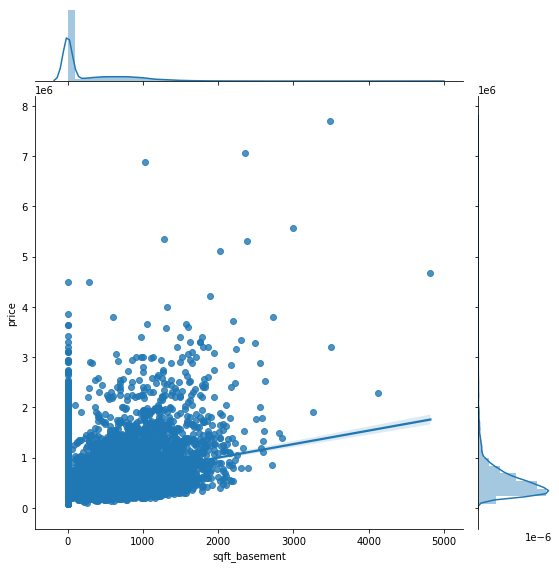

In [146]:
sns.jointplot(x='sqft_basement', y='price', data=data, kind='reg', height=8);

> - There may be a linear relationship between price and basement square footage. However, there are definite outliers that may need to be removed and this variable is zero-inflated. 
- This variable may work as a continuous variable, but used in that way it might be highly correlated with other sqft metrics. One way to get around this and still capture information about the basement would be to turn this into a binary categorical variable: either the house has a basement (1) or it doesn't (0).

In [147]:
def col_to_binary(series):
    """Takes in a column from a Pandas DataFrame and returns the column transformed so that values
       are binary - either 0 or 1 - based on whether the value was 0 or greater than 0, respectively. 
       Specifically intended for use with zero-inflated columns, so note that the function 
       does automatically convert NaN values to 0."""
    if series > 0:
        return 1
    else:
        return 0

In [148]:
## transform sqft_basement column to boolean basement or no basement and rename
data['basement'] = data['sqft_basement'].apply(lambda x: col_to_binary(x))
check_col(data['basement'])

*** basement ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 0    12999
1     8421
Name: basement, dtype: int64
---------------
Min: 0
Max:1


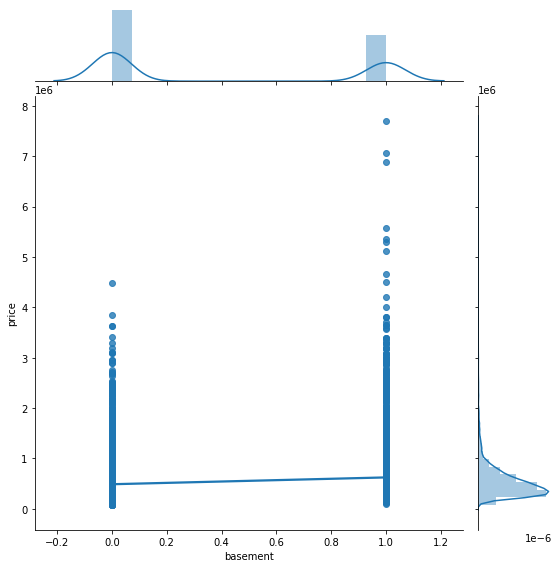

In [149]:
sns.jointplot(x='basement', y='price', data=data, kind='reg', height=8);

> - Again it appears there may be a slight relationship between the price of a house and whether or not it has a basement.

### Sqft_living

*** sqft_living ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 1300    136
1440    133
1400    132
1660    128
1800    128
       ... 
4970      1
2905      1
2793      1
4810      1
1975      1
Name: sqft_living, Length: 1034, dtype: int64
---------------
Min: 370
Max:13540
None


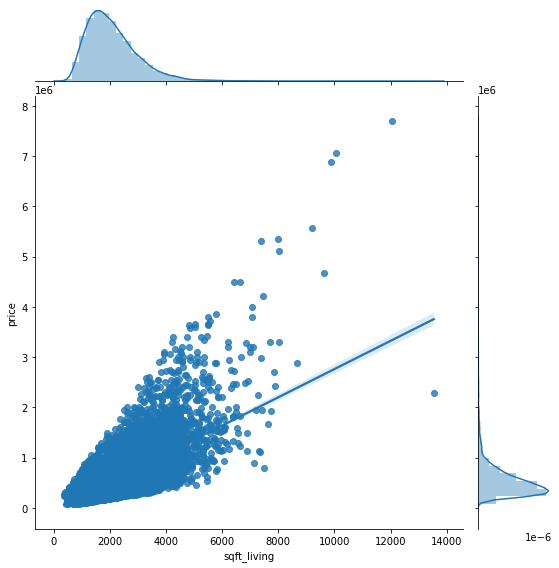

In [150]:
print(check_col(data['sqft_living']))
sns.jointplot(x='sqft_living', y='price', data=data, kind='reg', height=8);

> - There does appear to be a linear relationship between price and square footage of living space, and there are definitely outliers here that may need to be removed.
- Sqft_living is a continuous variable and may be improved as a predictor through log transformation since this would reduce the right-skewedness of the data. Outliers should be removed prior to log transformation.

### Sqft_living15

*** sqft_living15 ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 1540    193
1560    190
1440    190
1500    178
1460    168
       ... 
4890      1
2873      1
952       1
3193      1
2049      1
Name: sqft_living15, Length: 777, dtype: int64
---------------
Min: 399
Max:6210
None


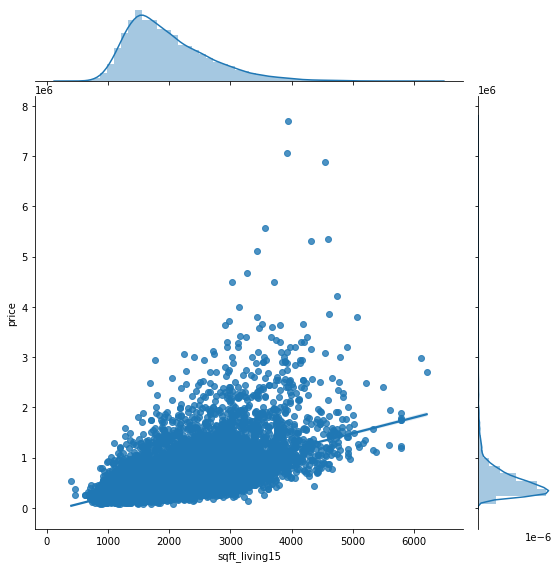

In [152]:
print(check_col(data['sqft_living15']))
sns.jointplot(x='sqft_living15', y='price', data=data, kind='reg', height=8);

> - There is a relatively linear relationship between the average square footage of living space of the neighboring houses and price. This is not surprising since the sqft_living of neighboring houses is likely to be similar to that of the house in question and the section above demonstrated a relationship between those two variables. Thus, this variable is likely highly correlated with sqft_living and should not be included in the model to avoid problems associated with multicollinearity if sqft_living is found to be a better predictor of price.

### Diff_sqft_living15

*** diff_sqft_living15 ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
  0       2541
-10       238
-40       200
-50       195
 50       188
         ... 
-362        1
 92         1
 2125       1
 454        1
 4030       1
Name: diff_sqft_living15, Length: 1018, dtype: int64
---------------
Min: -2310
Max:8690
None


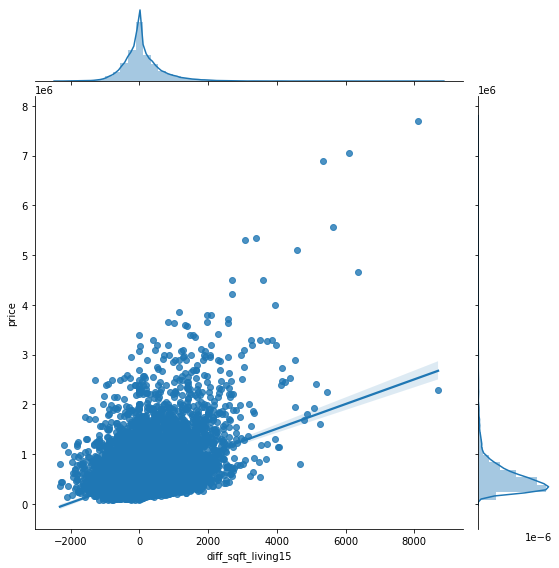

In [153]:
print(check_col(data['diff_sqft_living15']))
sns.jointplot(x='diff_sqft_living15', y='price', data=data, kind='reg', height=8);

> - There does appear to be a linear relationship such that with increasing living square footage compared to your neighbors, your house tends to sell for a higher price. However, this trend might be driven mostly by outliers.

### Sqft_lot

*** sqft_lot ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 5000      355
6000      286
4000      249
7200      218
7500      118
         ... 
9133        1
64438       1
953         1
969         1
315374      1
Name: sqft_lot, Length: 9776, dtype: int64
---------------
Min: 520
Max:1651359
None


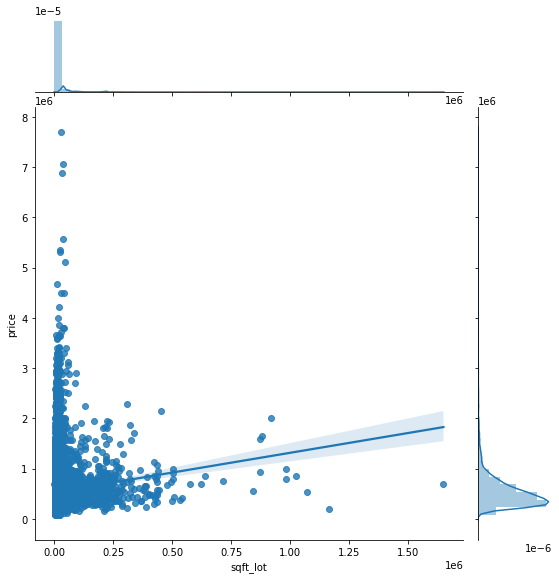

In [154]:
print(check_col(data['sqft_lot']))
sns.jointplot(x='sqft_lot', y='price', data=data, kind='reg', height=8);

> - Price and the square footage of the lot on which a house resides do not appear to be strongly related.

### Sqft_lot15

*** sqft_lot15 ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 5000     425
4000     354
6000     285
7200     209
4800     144
        ... 
11068      1
21315      1
35656      1
13135      1
6147       1
Name: sqft_lot15, Length: 8682, dtype: int64
---------------
Min: 651
Max:871200
None


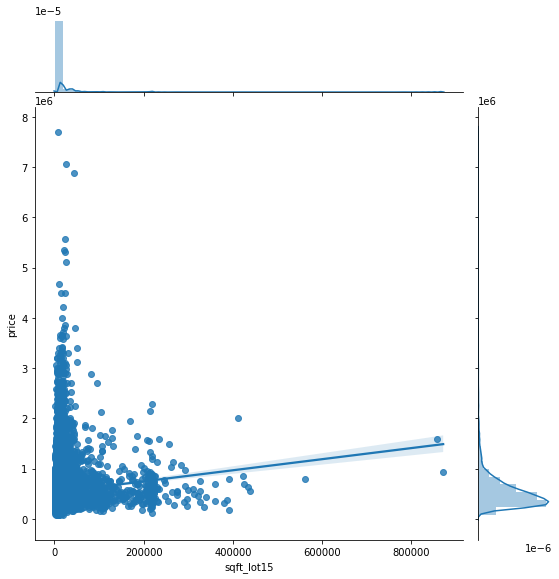

In [155]:
print(check_col(data['sqft_lot15']))
sns.jointplot(x='sqft_lot15', y='price', data=data, kind='reg', height=8);

> - Price and the average square footage of neighboring lots do not appear to be strongly related. This is not surprising given that lot size is probably very similar among neighbors, and no trend was found between price and sqft_lot.

### Diff_sqft_lot15

*** diff_sqft_lot15 ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
  0       4436
-1         62
-600       54
 1000      52
-200       49
         ... 
-2945       1
 4186       1
 2318       1
 894        1
-3361       1
Name: diff_sqft_lot15, Length: 7159, dtype: int64
---------------
Min: -326879
Max:1225778
None


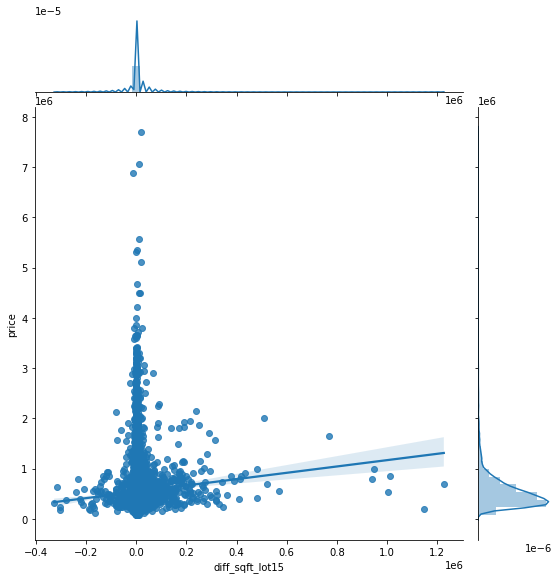

In [156]:
print(check_col(data['diff_sqft_lot15']))
sns.jointplot(x='diff_sqft_lot15', y='price', data=data, kind='reg', height=8);

> - Once again, lot size and price do not appear to be strongly related in any way.

### Waterfront

*** waterfront ***
---------------
Data Type: float64
% Null: 10.891690009337069
---------------
Value Counts:
 0.000    18941
nan       2333
1.000      146
Name: waterfront, dtype: int64
---------------
Min: 0.0
Max:1.0
None


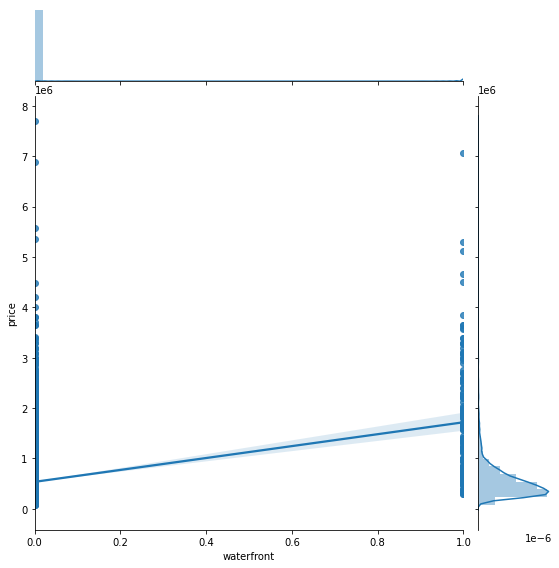

In [157]:
print(check_col(data['waterfront']))
sns.jointplot(x='waterfront', y='price', data=data, kind='reg', height=8);

> - There is some evidence that price is higher for waterfront homes.
- This variable has 2333 missing values and is extremely zero-inflated. Imputing the mode (0, non-waterfront) for the missing values (below) does not seem to impact the observed trend.

*** waterfront ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 0    21274
1      146
Name: waterfront, dtype: int64
---------------
Min: 0
Max:1
None


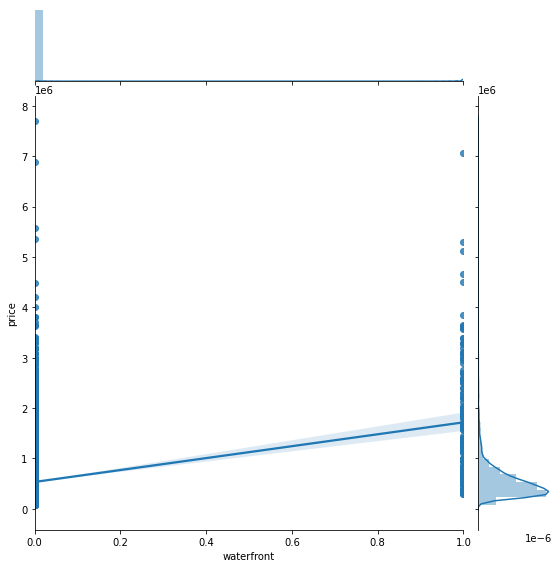

In [158]:
## replace NaN's in waterfront column with mode of 0
data['waterfront'] = data['waterfront'].apply(lambda x: col_to_binary(x))
print(check_col(data['waterfront']))
sns.jointplot(x='waterfront', y='price', data=data, kind='reg', height=8);

> - Now virtually all the houses are not waterfront (which was basically already the case).
- This variable is by nature a binary categorical variable.

### Yr_renovated

*** yr_renovated ***
---------------
Data Type: float64
% Null: 17.647058823529413
---------------
Value Counts:
 0.000       16900
nan          3780
2014.000       73
2003.000       31
2013.000       31
            ...  
1944.000        1
1953.000        1
1951.000        1
1946.000        1
1950.000        1
Name: yr_renovated, Length: 71, dtype: int64
---------------
Min: 0.0
Max:2015.0
None


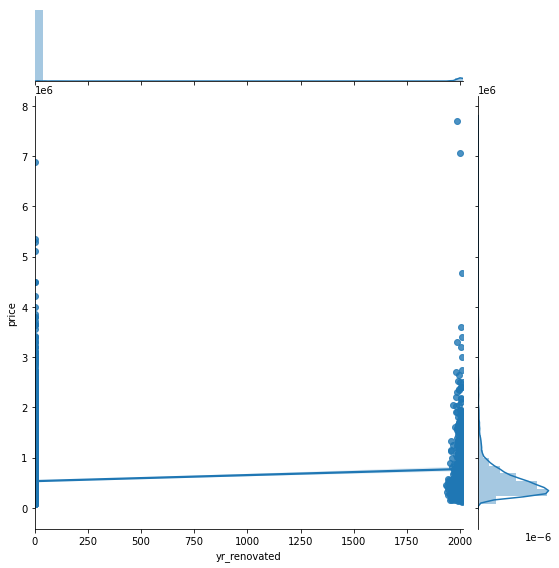

In [159]:
print(check_col(data['yr_renovated']))
sns.jointplot(x='yr_renovated', y='price', data=data, kind='reg', height=8);

In [160]:
print('Null values: {}%'.format(round((data['yr_renovated'].isna().sum() / len(data)) * 100, 2)))
print('Zero values: {}%'.format(round((len(data.loc[data['yr_renovated']==0]) / len(data)) * 100, 2)))

Null values: 17.65%
Zero values: 78.9%


> - This variable is extremeley zero-inflated and has a substantial proportion of missing values (nearly 18%). 

Number of renovated houses: 740
Number of houses renovated since 2010: 150
Number of houses renovated since 2005: 265
Number of houses renovated since 2000: 379
Number of houses renovated since 1995: 445
Number of houses renovated since 1990: 521
Number of houses renovated since 1980: 643
Number of houses renovated since 1970: 685
Number of houses renovated since 1960: 715
Number of houses renovated since 1950: 731

*** yr_renovated ***
---------------
Data Type: float64
% Null: 83.6283185840708
---------------
Value Counts:
 nan         3780
2014.000      73
2013.000      31
2003.000      31
2007.000      30
            ... 
1946.000       1
1953.000       1
1954.000       1
1951.000       1
1934.000       1
Name: yr_renovated, Length: 70, dtype: int64
---------------
Min: 1934.0
Max:2015.0
None


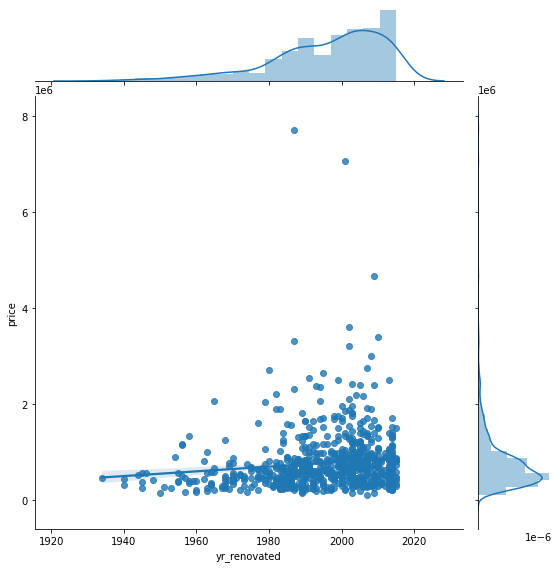

In [161]:
## check trends for the houses that have been renovated
print('Number of renovated houses: {}'.format(len(data.loc[data['yr_renovated']!=0].dropna())))
for year in [2010, 2005, 2000, 1995, 1990, 1980, 1970, 1960, 1950]:
    print('Number of houses renovated since {}: {}'.format(
                                                    year, 
                                                    len(data.loc[(data['yr_renovated']>=year)
                                                                ].dropna())))
print()
print(check_col(data.loc[data['yr_renovated']!=0]['yr_renovated']))
sns.jointplot(x='yr_renovated', y='price', data=data.loc[data['yr_renovated']!=0], kind='reg', height=8);

> - There are some definite outliers here, but it does seem like price tends to increase the more recently a house was renovated. However, only 445 houses have been renovated in the past 2 decades. Does it really matter if a house was renovated if that occurred decades ago?

In [162]:
def bin_by_decade(year):
    """Assign a decade based on year."""
    if year > 2009:
        return 2010
    elif (year < 2010) & (year > 1999):
        return 2000
    elif (year < 2000) & (year > 1989):
        return 1990
    elif (year < 1990) & (year > 1979):
        return 1980
    elif (year < 1980) & (year > 1969):
        return 1970
    elif (year < 1970) & (year > 1959):
        return 1960
    elif (year < 1960) & (year > 1949):
        return 1950
    elif (year < 1950) & (year > 1939):
        return 1940
    elif (year < 1940) & (year > 1929):
        return 1930
    else:
        return year

In [163]:
data['dec_renovated'] = data['yr_renovated'].apply(bin_by_decade)
check_col(data['dec_renovated'])

*** dec_renovated ***
---------------
Data Type: float64
% Null: 17.647058823529413
---------------
Value Counts:
 0.000       16900
nan          3780
2000.000      229
2010.000      150
1990.000      142
1980.000      122
1970.000       42
1960.000       30
1950.000       16
1940.000        8
1930.000        1
Name: dec_renovated, dtype: int64
---------------
Min: 0.0
Max:2010.0


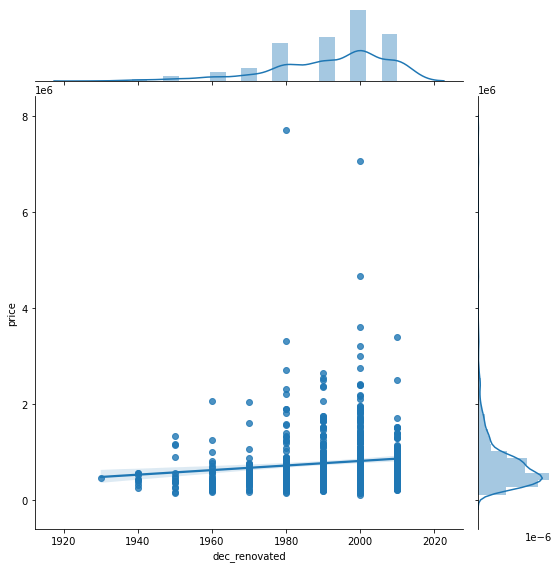

In [164]:
sns.jointplot(x='dec_renovated', y='price', data=data.loc[data['dec_renovated']!=0], kind='reg', height=8);

> - There are still some definite outliers here, but it still seems like price tends to increase the more recently a house was renovated.

In [165]:
data['dec_reno_cat_unk'] = data['dec_renovated'].fillna(value='Unknown').astype('category')
check_col(data['dec_reno_cat_unk'])

*** dec_reno_cat_unk ***
---------------
Data Type: category
% Null: 0.0
---------------
Value Counts:
 0.0        16900
Unknown     3780
2000.0       229
2010.0       150
1990.0       142
1980.0       122
1970.0        42
1960.0        30
1950.0        16
1940.0         8
1930.0         1
Name: dec_reno_cat_unk, dtype: int64
---------------


<AxesSubplot:xlabel='dec_reno_cat_unk', ylabel='price'>

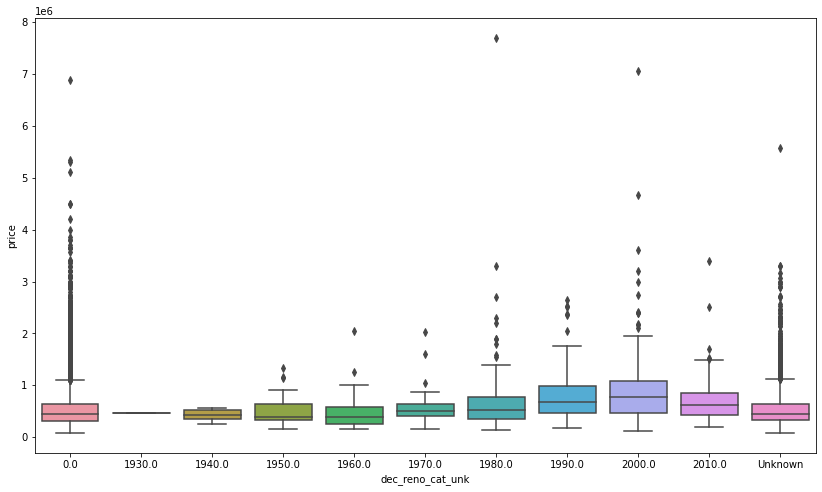

In [166]:
plt.figure(figsize=(14,8))
sns.boxplot(x=data['dec_reno_cat_unk'], y=data['price'])

> - It still appears as if there may be some affect of more recent renovations on price. The distribution of the 'unknown' (missing value) category seen above looks very to that of the category for houses that were never renovated (0.0). The two categories are combined below.

In [167]:
data['dec_reno_cat_fill0'] = data['dec_renovated'].fillna(value=0).astype('category')
check_col(data['dec_reno_cat_fill0'])

*** dec_reno_cat_fill0 ***
---------------
Data Type: category
% Null: 0.0
---------------
Value Counts:
 0.000       20680
2000.000      229
2010.000      150
1990.000      142
1980.000      122
1970.000       42
1960.000       30
1950.000       16
1940.000        8
1930.000        1
Name: dec_reno_cat_fill0, dtype: int64
---------------


<AxesSubplot:xlabel='dec_reno_cat_fill0', ylabel='price'>

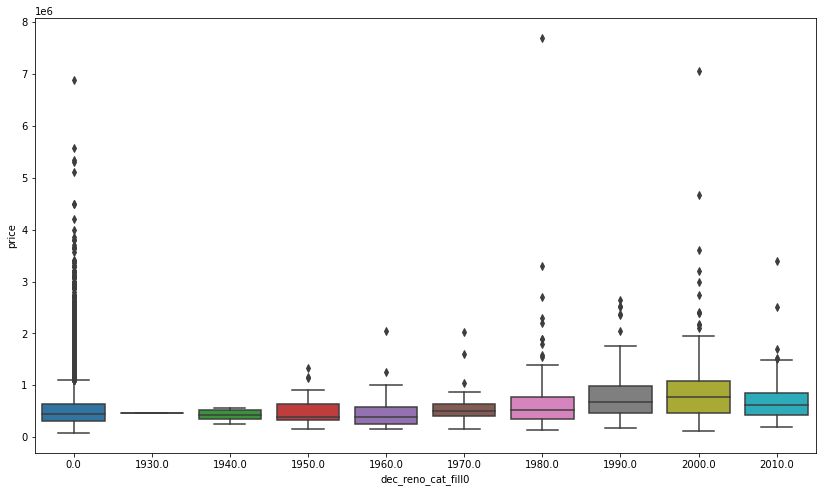

In [168]:
plt.figure(figsize=(14,8))
sns.boxplot(x=data['dec_reno_cat_fill0'], y=data['price'])

> - The majority of the houses were never renovated, so it could also make sense to recast yr_renovated as a binary categorical variable: renovated (1) or never renovated (0).

*** renovated ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 0    20680
1      740
Name: renovated, dtype: int64
---------------
Min: 0
Max:1
None


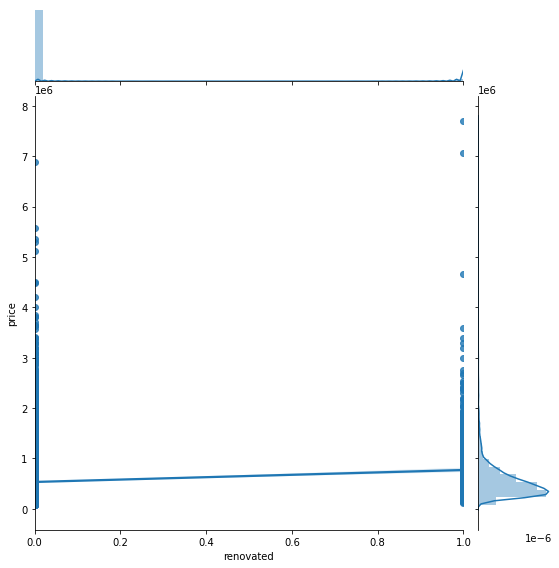

In [169]:
## create a column that bins yr_renovated as either renovated or never renovated 
data['renovated'] = data['yr_renovated'].apply(lambda x: col_to_binary(x))
print(check_col(data['renovated']))
sns.jointplot(x='renovated', y='price', data=data, kind='reg', height=8);

> - There may be a slight increase in price for those houses that were renovated compared to those that weren't.

### Lat

*** lat ***
---------------
Data Type: float64
% Null: 0.0
---------------
Value Counts:
 47.662    17
47.532    17
47.549    17
47.685    17
47.671    16
          ..
47.749     1
47.655     1
47.398     1
47.599     1
47.272     1
Name: lat, Length: 5033, dtype: int64
---------------
Min: 47.1559
Max:47.7776
None


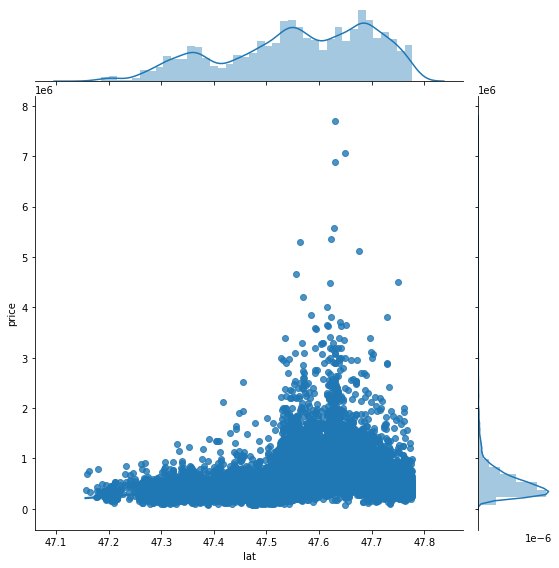

In [170]:
print(check_col(data['lat']))
sns.jointplot(x='lat', y='price', data=data, kind='reg', height=8);

> - It's possible that price tends to increase with increasing latitude (further north), but this may be mostly driven by outliers.

### Long

*** long ***
---------------
Data Type: float64
% Null: 0.0
---------------
Value Counts:
 -122.290    113
-122.300    110
-122.362    102
-122.291    100
-122.363     99
           ... 
-122.467      1
-121.403      1
-121.804      1
-121.726      1
-121.893      1
Name: long, Length: 751, dtype: int64
---------------
Min: -122.51899999999999
Max:-121.315
None


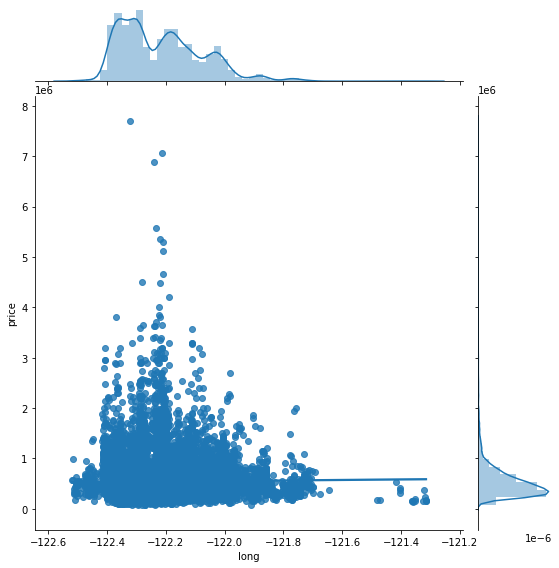

In [171]:
print(check_col(data['long']))
sns.jointplot(x='long', y='price', data=data, kind='reg', height=8);

> - There is no clearly discernible relationship between price and longitude.

### Zipcode

*** zipcode ***
---------------
Data Type: int64
% Null: 0.0
---------------
Value Counts:
 98103    600
98038    586
98115    576
98052    571
98117    548
        ... 
98102    104
98010     99
98024     79
98148     56
98039     49
Name: zipcode, Length: 70, dtype: int64
---------------
Min: 98001
Max:98199
None


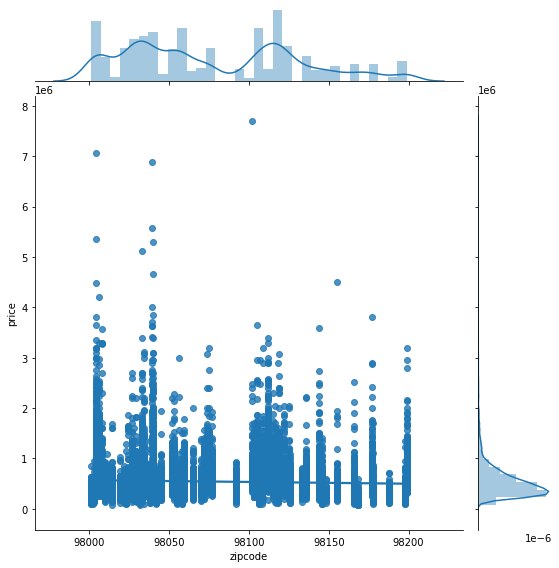

In [172]:
print(check_col(data['zipcode']))
sns.jointplot(x='zipcode', y='price', data=data, kind='reg', height=8);

> - There is not a linear relationship between zipcode and price, but this is not surprising since zipcode is better treated as a categorical variable.

In [173]:
## change zipcode to string to use as categorical
data['zipcode'] = data['zipcode'].astype('str')

## Check Correlations for All Variables

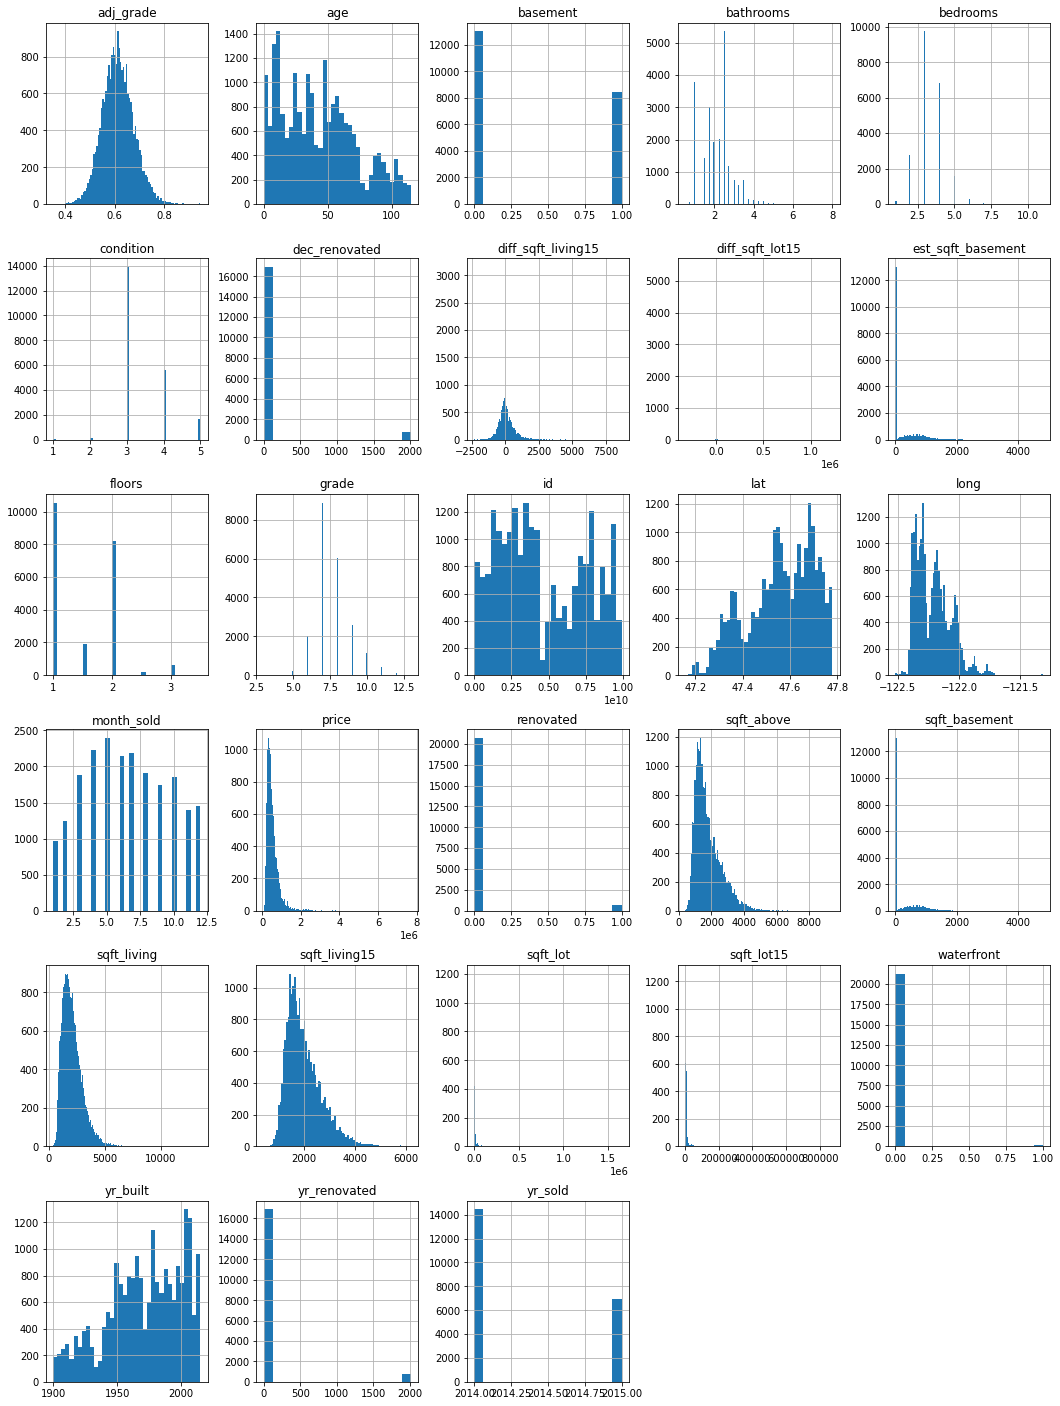

In [176]:
data.hist(figsize=(18, 25), bins='auto');

In [177]:
data.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold,age,diff_sqft_living15,diff_sqft_lot15,adj_grade,est_sqft_basement,basement,dec_renovated,renovated
id,1.000,-0.018,0.002,0.004,-0.013,-0.133,0.018,-0.004,-0.024,0.006,-0.012,-0.006,0.021,-0.012,-0.003,0.019,-0.004,-0.139,0.010,-0.011,-0.021,-0.016,-0.058,0.022,-0.006,0.002,-0.012,-0.011
price,-0.018,1.000,0.317,0.525,0.701,0.089,0.255,0.265,0.034,0.667,0.604,0.324,0.051,0.130,0.306,0.020,0.584,0.082,0.001,-0.008,-0.051,0.406,0.050,0.076,0.324,0.180,0.130,0.118
bedrooms,0.002,0.317,1.000,0.529,0.594,0.034,0.184,-0.002,0.023,0.368,0.494,0.309,0.160,0.019,-0.013,0.137,0.406,0.032,-0.010,-0.001,-0.161,0.445,0.018,-0.332,0.309,0.164,0.019,0.018
bathrooms,0.004,0.525,0.529,1.000,0.756,0.088,0.502,0.064,-0.129,0.666,0.686,0.283,0.506,0.052,0.023,0.224,0.569,0.088,-0.029,0.009,-0.507,0.505,0.043,-0.084,0.283,0.163,0.052,0.047
sqft_living,-0.013,0.701,0.594,0.756,1.000,0.173,0.353,0.105,-0.062,0.762,0.877,0.435,0.317,0.056,0.051,0.240,0.756,0.184,-0.031,0.014,-0.317,0.666,0.074,-0.235,0.435,0.203,0.056,0.051
sqft_lot,-0.133,0.089,0.034,0.088,0.173,1.000,-0.006,0.021,-0.009,0.114,0.183,0.015,0.052,0.005,-0.086,0.230,0.144,0.718,0.005,-0.003,-0.052,0.100,0.755,-0.055,0.015,-0.036,0.005,0.005
floors,0.018,0.255,0.184,0.502,0.353,-0.006,1.000,0.021,-0.267,0.458,0.523,-0.246,0.489,0.003,0.049,0.125,0.279,-0.011,-0.024,0.016,-0.489,0.221,0.003,0.171,-0.246,-0.257,0.003,0.003
waterfront,-0.004,0.265,-0.002,0.064,0.105,0.021,0.021,1.000,0.017,0.083,0.072,0.083,-0.025,0.082,-0.012,-0.038,0.084,0.031,-0.005,0.008,0.025,0.064,0.002,-0.001,0.083,0.040,0.082,0.074
condition,-0.024,0.034,0.023,-0.129,-0.062,-0.009,-0.267,0.017,1.000,-0.151,-0.161,0.174,-0.365,-0.062,-0.016,-0.107,-0.095,-0.003,-0.048,0.024,0.364,0.014,-0.010,-0.144,0.174,0.136,-0.062,-0.056
grade,0.006,0.667,0.368,0.666,0.762,0.114,0.458,0.083,-0.151,1.000,0.756,0.167,0.446,0.017,0.113,0.199,0.713,0.120,-0.033,0.012,-0.447,0.352,0.050,0.408,0.167,0.050,0.017,0.015


In [178]:
cols_to_drop = ['est_sqft_basement', 'yr_built']
data.drop(columns=cols_to_drop, inplace=True)

<AxesSubplot:>

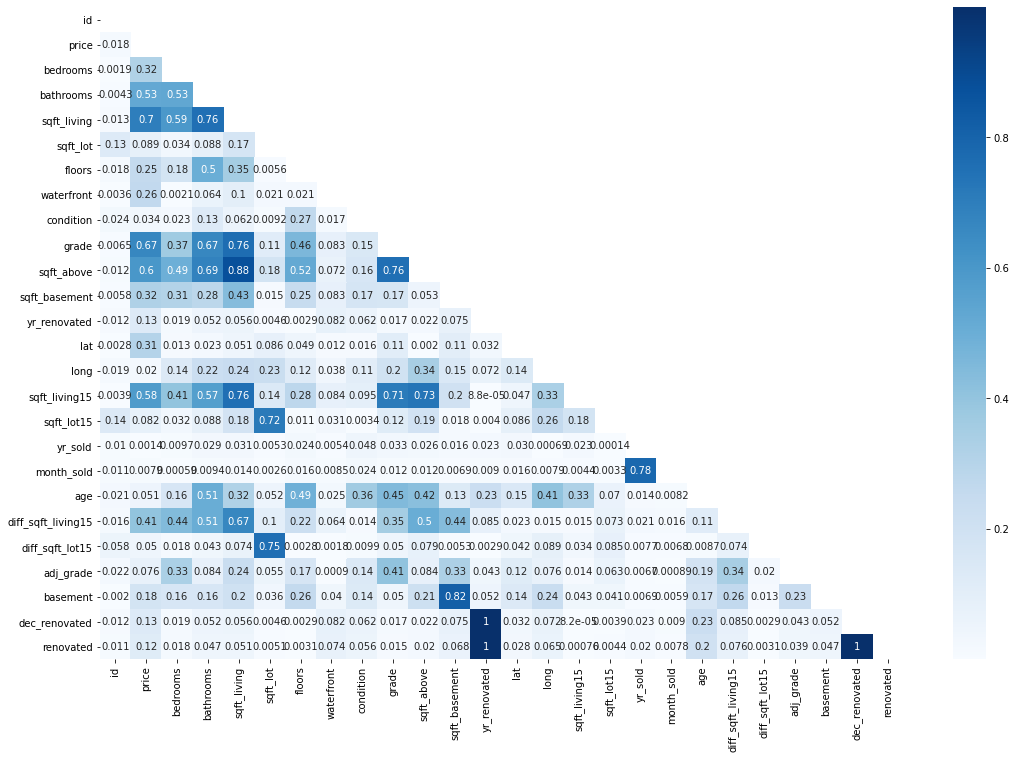

In [323]:
corr = data.corr().abs()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
mask
plt.figure(figsize=(18,12))
sns.heatmap(corr, annot=True, cmap='Blues', mask=mask)

Variables that are highly correlated need to be dropped to reduce the problems associated with multicollinearity when building regression models. 

The grade column is a summary statistic/ metric awarded by the county based on certain criteria. These criteria may include or be closely related to the number of bathrooms in a house, the square footage of the living area, the number of floors, the age of the house, and the above ground square footage of the house because grade correlates relatively well with each of those variables. I would rather include more of the nuances of those variables, rather than collapse them down into a single summary statistic, so I will not include grade in the model. 

The square footage above-ground variable is highly correlated with the square footage of living space, especially since most houses do not have basements. Square footage of living space is more highly correlated with price, so I will likely keep that variable in the model, as well as a basement variable, and drop sqft_above. Both the sqft_living and sqft_above variables are also highly correlated with the number of bathrooms.

The month a house was sold is highly correlated with the year the house was sold. It would make the most sense to keep the month that the house was sold in the model, because that's at least something the seller could possibly work with (holding off on accepting lower offers until a certain season when houses tend to sell for more). The model may be slightly more accurate at predicting the current dataset if year were included, but that information doesn't necessarily help make predictions for houses sold outside of 2014 and 2015. The season_sold variable is an alternative to month_sold, but it doesn't show up in this matrix because it is a nominal categorical variable.

The sqft_lot15 and sqft_living15 variables (averages for 15 nearest neighbors) are highly correlated with the sqft_lot and sqft_living (respectively) of the house itself, so I'll probably only want to include the information about the house itself in the model.

## ANSWER: QUESTION 1

The following variables will be included in the model:
- **Continuous**
 - sqft_living
 - sqft_basement
 - age
 - diff_sqft_living15
 - lat
 
 
- **Ordinal Categorical**
 - bedrooms
 - bathrooms
 - floors
 - grade
 

- **Categorical**
 - waterfront
 - condition
 - renovated
 - zipcode
 
 
The remaining variables will not be included in the model either because they were found to have no clear relationship with price (yr_sold, month_sold, season_sold, diff_sqft_lot15, long, sqft_lot), they are highly correlated with sqft_living which is most highly correlated with price (sqft_living15, sqft_above), or they are an alternative form of a variable selected to use in the model (e.g. choose dec_reno_cat_fill0 so leave out other forms of year renovated variable).

#### Random transformation stuff

In [ ]:
data['age_plus_1'] = data['age'] + 1
data.describe()

In [ ]:
continuous = ['price', 'sqft_living', 'sqft_lot', 'age_plus_1']
data_cont = data[continuous]
log_names = [f'{col}_log' for col in data_cont.columns]
data_log = np.log(data_cont)
data_log.columns = log_names
data_log.head()

In [ ]:
def standardize(feature):
    """Takes in a series/ column and transforms that feature to have a mean of zero 
       and a standard deviation of 1."""
    return (feature - feature.mean()) / feature.std()

In [ ]:
data_log_stdz = data_log.apply(standardize)
data_log_stdz.describe()

In [ ]:
numerical = ['bedrooms', 'bathrooms', 'floors', 'diff_sqft_living15', 'diff_sqft_lot15', ]
data_num = data[numerical]
data_num_stdz = data_num.apply(standardize)
data_num_stdz.describe()

In [ ]:
categorical = ['waterfront', 'basement', 'zipcode', 'month_sold', 'renovated']
data_cat = data[categorical].astype('str')
data_cat.info()

In [ ]:
data_ohe = pd.get_dummies(data_cat, drop_first=True)
data_ohe

In [ ]:
init_model_data = pd.concat([data['id'], data_log_stdz, data_num_stdz, data_ohe], axis=1)
init_model_data

# EXPLORE

## QUESTION 2: How does the method of outlier removal influence model performance?

In [302]:
## Check for outliers
from scipy import stats

def z_outliers(variable, cutoff=3 , verbose=True):
    
    """Takes in a variable as a series/ dataframe column and calculates the absolute value of the 
       z-score for each observation. It returns a series with the same index as the data with True 
       if the observation is an outlier (defined as having a z-score of 3 standard deviations (default) 
       from the mean) or False if the observation is not an outlier."""
    
    z_scores = np.abs(stats.zscore(variable))
    z_scores = pd.Series(z_scores, index=variable.index)
    idx_outliers = z_scores > cutoff
    
    if verbose:
        print('Z-score method found {} outliers.'.format(idx_outliers.sum()))
    
    return idx_outliers





def IQR_outliers(variable, verbose=True):
    
    """Takes in a variable as a series/ dataframe column and calculates the absolute value of the 
       z-score for each observation. It returns a series with the same index as the data with True 
       if the observation is an outlier (defined as having a z-score of 3 standard deviations (default) 
       from the mean) or False if the observation is not an outlier."""
    
    upper_q = variable.quantile(q=0.75)
    lower_q = variable.quantile(q=0.25)
    IQR = upper_q - lower_q
    thresh = 1.5*IQR
    
    idx_outliers = (variable < lower_q-thresh) | (variable > upper_q+thresh)
    
    if verbose:
        print('IQR method found {} outliers.'.format(idx_outliers.sum()))
    
    return idx_outliers

In [300]:
def top_quantiles(series, start=90, stop=100):
    """Takes in a DataFrame column or series and returns the quantiles between start and stop. 
       Default is to start at 90 and stop at 100 (exclusive)."""
    for q in range(start, stop):
        print('{}% quantile: {}'.format(q, series.quantile(q=(q/100))))

### Price Outliers

In [301]:
price_z_outliers = z_outliers(data['price'])
price_z_outliers

Z-score method found 404 outliers.


0        False
1        False
2        False
3        False
4        False
         ...  
21592    False
21593    False
21594    False
21595    False
21596    False
Length: 21420, dtype: bool

In [303]:
price_IQR_outliers = IQR_outliers(data['price'])
price_IQR_outliers

IQR method found 1152 outliers.


0        False
1        False
2        False
3        False
4        False
         ...  
21592    False
21593    False
21594    False
21595    False
21596    False
Name: price, Length: 21420, dtype: bool

In [306]:
data_z = data[~price_z_outliers]
data_IQR = data[~price_IQR_outliers]

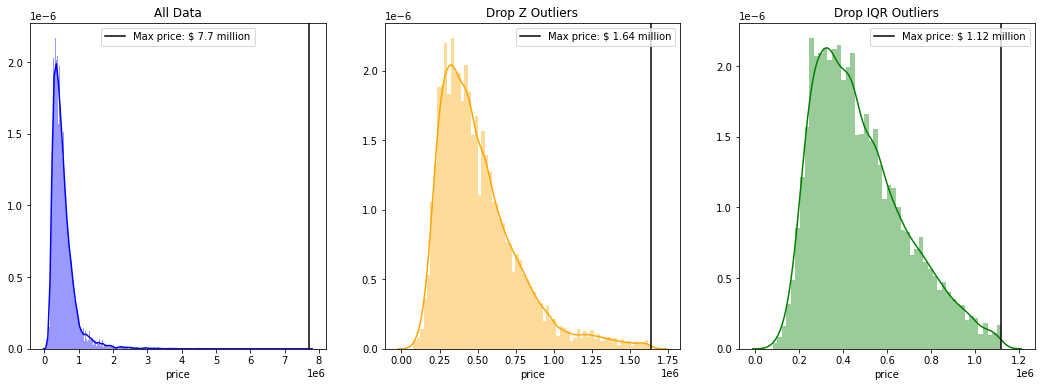

In [379]:
fig, axes = plt.subplots(ncols=3, figsize=(18,6))
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]

sns.distplot(data['price'], bins='auto', color='b', ax=ax1)
ax1.set_title('All Data')
ax1.axvline(x=data['price'].max(), color='k',
            label='Max price: $ {} million'.format(data['price'].max() / 1000000))
ax1.legend()

sns.distplot(data_z['price'], bins='auto', color='orange', ax=ax2)
ax2.set_title('Drop Z Outliers')
ax2.axvline(x=data_z['price'].max(), color='k',
            label='Max price: $ {} million'.format(data_z['price'].max() / 1000000))
ax2.legend()

sns.distplot(data_IQR['price'], bins='auto', color='g', ax=ax3)
ax3.set_title('Drop IQR Outliers')
ax3.axvline(x=data_IQR['price'].max(), color='k',
            label='Max price: $ {} million'.format(data_IQR['price'].max() / 1000000))
ax3.legend()

plt.show()

>- The IQR method is more stringent in terms of what it considers an outlier. It removed nearly 3 times the number of observations than removing outliers based on z-scores (1152 observations compared to 404).
- Removing price outliers has definitely reduced the skew of this variable, making the distributions appear closer to normal, though they are still right-skewed (the z-score cleaned data more so than the IQR cleaned data).

In [384]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_renovated,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold,age,diff_sqft_living15,diff_sqft_lot15,adj_grade,basement,dec_renovated,renovated
count,21420.000,21420.000,21420.000,21420.000,21420.000,21420.000,21420.000,21420.000,21420.000,21420.000,21420.000,21420.000,17640.000,21420.000,21420.000,21420.000,21420.000,21420.000,21420.000,21420.000,21420.000,21420.000,21420.000,21420.000,17640.000,21420.000
mean,4580939869.158,541861.428,3.373,2.118,2083.133,15128.038,1.496,0.007,3.411,7.663,1791.170,291.962,83.733,47.560,-122.214,1988.384,12775.718,2014.325,6.564,43.233,94.749,2352.320,0.615,0.393,83.550,0.035
std,2876761172.448,367556.938,0.903,0.769,918.808,41530.797,0.540,0.082,0.650,1.172,828.693,442.876,400.176,0.139,0.141,685.537,27345.622,0.468,3.118,29.389,601.300,29022.926,0.064,0.488,399.303,0.183
min,1000102.000,78000.000,1.000,0.500,370.000,520.000,1.000,0.000,1.000,3.000,370.000,0.000,0.000,47.156,-122.519,399.000,651.000,2014.000,1.000,0.000,-2310.000,-326879.000,0.352,0.000,0.000,0.000
25%,2123537386.750,324950.000,3.000,1.750,1430.000,5040.000,1.000,0.000,3.000,7.000,1200.000,0.000,0.000,47.471,-122.328,1490.000,5100.000,2014.000,4.000,17.000,-220.000,-420.250,0.572,0.000,0.000,0.000
50%,3904921185.000,450550.000,3.000,2.250,1920.000,7614.000,1.500,0.000,3.000,7.000,1560.000,0.000,0.000,47.572,-122.230,1840.000,7620.000,2014.000,6.000,39.000,0.000,0.000,0.613,0.000,0.000,0.000
75%,7308900186.250,645000.000,4.000,2.500,2550.000,10690.500,2.000,0.000,4.000,8.000,2220.000,560.000,0.000,47.678,-122.125,2370.000,10086.250,2015.000,9.000,63.000,310.000,680.000,0.655,1.000,0.000,0.000
max,9900000190.000,7700000.000,11.000,8.000,13540.000,1651359.000,3.500,1.000,5.000,13.000,9410.000,4820.000,2015.000,47.778,-121.315,6210.000,871200.000,2015.000,12.000,115.000,8690.000,1225778.000,0.946,1.000,2010.000,1.000


In [385]:
data_z.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_renovated,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold,age,diff_sqft_living15,diff_sqft_lot15,adj_grade,basement,dec_renovated,renovated
count,21016.000,21016.000,21016.000,21016.000,21016.000,21016.000,21016.000,21016.000,21016.000,21016.000,21016.000,21016.000,17311.000,21016.000,21016.000,21016.000,21016.000,21016.000,21016.000,21016.000,21016.000,21016.000,21016.000,21016.000,17311.000,21016.000
mean,4593098963.197,508447.459,3.355,2.090,2035.155,14863.675,1.489,0.004,3.409,7.610,1754.007,281.148,79.438,47.559,-122.214,1962.135,12652.113,2014.325,6.568,43.304,73.020,2211.562,0.614,0.388,79.265,0.033
std,2878358699.358,259118.064,0.893,0.736,837.254,40539.842,0.539,0.062,0.648,1.107,773.120,425.524,390.202,0.139,0.142,655.487,27269.212,0.468,3.117,29.299,552.834,28248.055,0.064,0.487,389.352,0.178
min,1000102.000,78000.000,1.000,0.500,370.000,520.000,1.000,0.000,1.000,3.000,370.000,0.000,0.000,47.156,-122.519,399.000,651.000,2014.000,1.000,0.000,-2310.000,-326879.000,0.352,0.000,0.000,0.000
25%,2126049139.500,320000.000,3.000,1.500,1420.000,5001.750,1.000,0.000,3.000,7.000,1190.000,0.000,0.000,47.467,-122.329,1480.000,5079.750,2014.000,4.000,18.000,-220.000,-419.000,0.571,0.000,0.000,0.000
50%,3905030260.000,449500.000,3.000,2.250,1900.000,7560.000,1.500,0.000,3.000,7.000,1550.000,0.000,0.000,47.570,-122.231,1830.000,7573.000,2014.000,6.000,39.000,0.000,0.000,0.612,0.000,0.000,0.000
75%,7334500097.500,630000.000,4.000,2.500,2510.000,10496.250,2.000,0.000,4.000,8.000,2170.000,540.000,0.000,47.679,-122.124,2330.000,10000.000,2015.000,9.000,63.000,300.000,661.000,0.655,1.000,0.000,0.000
max,9900000190.000,1640000.000,11.000,7.500,7480.000,1651359.000,3.500,1.000,5.000,12.000,7320.000,2850.000,2015.000,47.778,-121.315,5790.000,871200.000,2015.000,12.000,115.000,5250.000,1225778.000,0.946,1.000,2010.000,1.000


In [386]:
data_IQR.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_renovated,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold,age,diff_sqft_living15,diff_sqft_lot15,adj_grade,basement,dec_renovated,renovated
count,20268.000,20268.000,20268.000,20268.000,20268.000,20268.000,20268.000,20268.000,20268.000,20268.000,20268.000,20268.000,16702.000,20268.000,20268.000,20268.000,20268.000,20268.000,20268.000,20268.000,20268.000,20268.000,20268.000,20268.000,16702.000,20268.000
mean,4604434224.741,478114.357,3.330,2.054,1977.859,14621.276,1.477,0.003,3.408,7.536,1710.504,267.355,74.199,47.557,-122.213,1923.787,12447.013,2014.325,6.568,43.419,54.072,2174.263,0.613,0.380,74.038,0.031
std,2877553234.694,207440.509,0.883,0.710,774.469,40148.186,0.537,0.050,0.647,1.035,727.681,409.136,377.605,0.141,0.142,615.155,26541.055,0.468,3.120,29.171,524.132,28386.927,0.064,0.485,376.787,0.172
min,1000102.000,78000.000,1.000,0.500,370.000,520.000,1.000,0.000,1.000,3.000,370.000,0.000,0.000,47.156,-122.519,399.000,651.000,2014.000,1.000,0.000,-2310.000,-326879.000,0.352,0.000,0.000,0.000
25%,2132807640.000,316000.000,3.000,1.500,1400.000,5000.000,1.000,0.000,3.000,7.000,1180.000,0.000,0.000,47.460,-122.330,1470.000,5040.000,2014.000,4.000,18.000,-230.000,-411.000,0.570,0.000,0.000,0.000
50%,3905081210.000,439000.000,3.000,2.000,1860.000,7500.000,1.000,0.000,3.000,7.000,1520.000,0.000,0.000,47.567,-122.231,1800.000,7538.500,2014.000,6.000,40.000,0.000,0.000,0.611,0.000,0.000,0.000
75%,7338200172.500,602000.000,4.000,2.500,2440.000,10320.000,2.000,0.000,4.000,8.000,2101.250,510.000,0.000,47.680,-122.122,2280.000,9890.000,2015.000,9.000,63.000,270.000,633.000,0.654,1.000,0.000,0.000
max,9900000190.000,1120000.000,11.000,7.500,7480.000,1651359.000,3.500,1.000,5.000,12.000,5710.000,2720.000,2015.000,47.778,-121.315,5380.000,871200.000,2015.000,12.000,115.000,4670.000,1225778.000,0.946,1.000,2010.000,1.000


<AxesSubplot:>

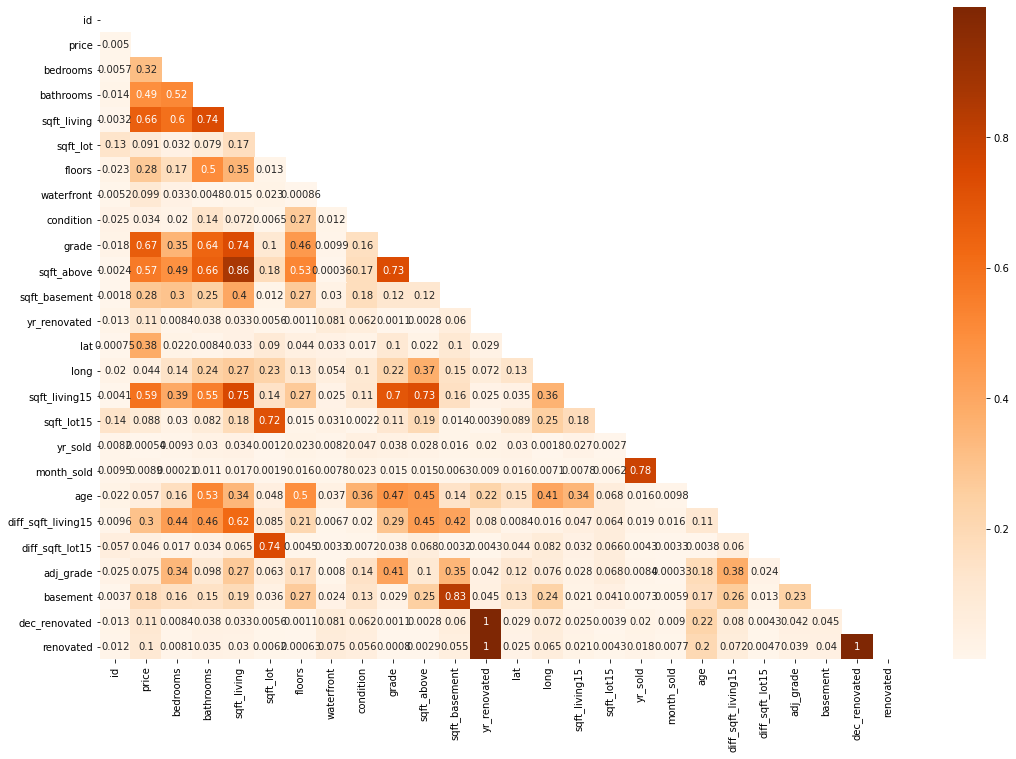

In [380]:
corr = data_z.corr().abs()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
mask
plt.figure(figsize=(18,12))
sns.heatmap(corr, annot=True, cmap='Oranges', mask=mask)

> - Now grade is slightly more correlated with price than sqft_living (grade:0.67, sqft_living: 0.66) whereas prior to outlier removal sqft_living was more strongly correlated with price than grade (grade: 0.67, sqft_living: 0.70). Grade and sqft_living are still strongly correlated (0.74), so only one should be included in a final model to avoid issues with multicollinearity.

<AxesSubplot:>

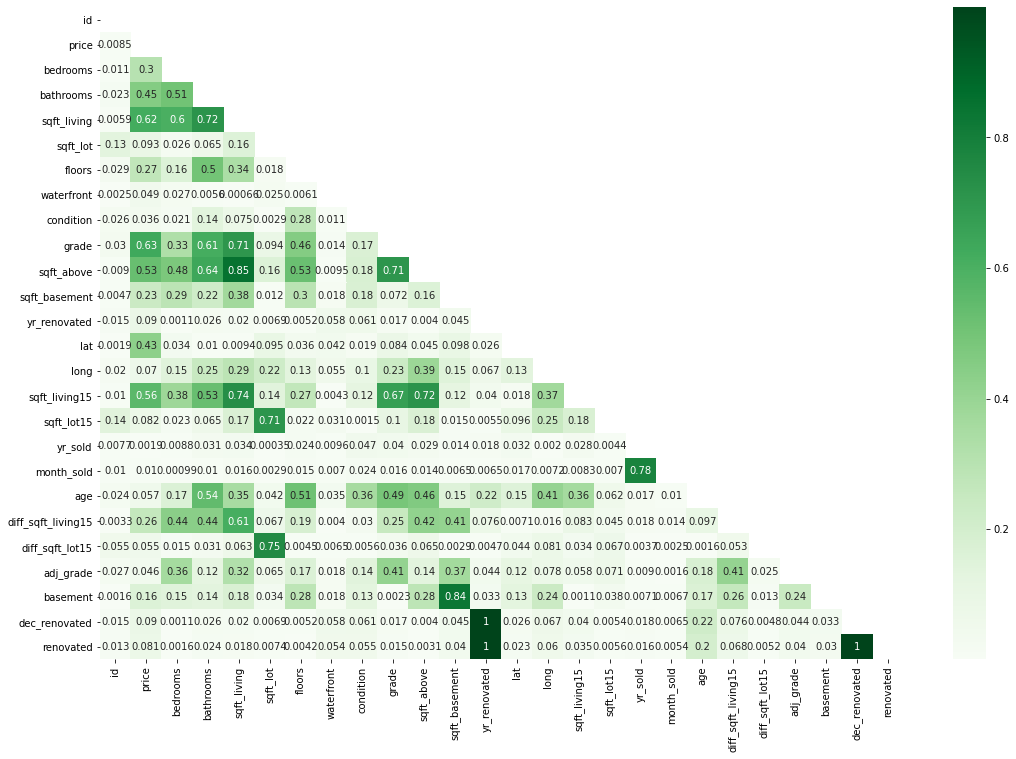

In [311]:
corr = data_IQR.corr().abs()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
mask
plt.figure(figsize=(18,12))
sns.heatmap(corr, annot=True, cmap='Greens', mask=mask)

> - As seen above, grade is slightly more correlated with price than sqft_living (grade:0.63, sqft_living: 0.62) whereas prior to outlier removal sqft_living was more strongly correlated with price than grade (grade: 0.67, sqft_living: 0.70). Grade and sqft_living are still strongly correlated (0.71), so only one should be included in a final model to avoid issues with multicollinearity.
- The strength of the correlations among these three variables is tending to decrease as more outliers are removed.

### Sqft_living Outliers

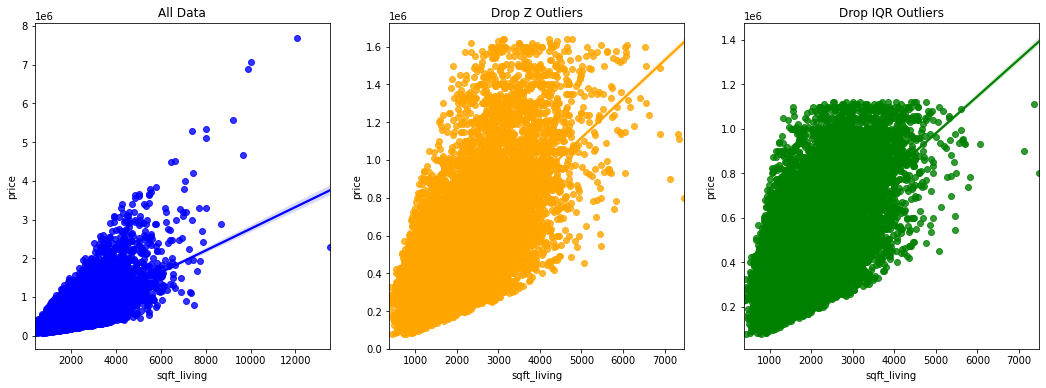

In [389]:
fig, axes = plt.subplots(ncols=3, figsize=(18,6))
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]

sns.regplot(x=data['sqft_living'], y=data['price'], color='b', ax=ax1)
ax1.set_title('All Data')


sns.regplot(x=data_z['sqft_living'], y=data_z['price'], color='orange', ax=ax2)
ax2.set_title('Drop Z Outliers')


sns.regplot(x=data_IQR['sqft_living'], y=data_IQR['price'], color='g', ax=ax3)
ax3.set_title('Drop IQR Outliers')

plt.show()

# MODEL

In [198]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

In [334]:
def build_model(target, numerical, categorical, data):
    
    """Takes in a target variable as a string (needs to be a column name in data), 
       a list of variables to be treated as numeric (must be column names in data),
       a list of variables to be treated as categories (must be column names in data - no one-hot encoded).
       Returns a Statsmodels OLS regression model."""
    
    model_vars = list(target) + numerical + categorical
    cat_features = [f'C({feat})' for feat in categorical]
    num_features = numerical
    feature_sum = '+'.join(num_features) + '+' + '+'.join(cat_features) 
    formula = target + '~' + feature_sum
    
    model = ols(formula=formula, data=data).fit()
    
    return model

In [381]:
def check_ols_assumptions(model, data, target):
    
    """Takes in a Statsmodel OLS regression model, the dataframe from which that model was generated,
       and the target variable of that model as a string (needs to be a column name in data).
       Returns a Q-Q plot of the residuals as well as a plot of the residuals against the target
       variable to vizualize homoscedasticity of model errors."""
    
    fig, ax = plt.subplots(ncols=2,figsize=(14,5))
    ax1 = ax[0]
    ax2 = ax[1]
    
    if (len(data) < 21420) & (len(data) > 21000):
        color='orange'
    elif (len(data) < 21000):
        color='g'
    else:
        color='b'

    sm.graphics.qqplot(model.resid, fit=True, line='45', ax=ax1, color=color)
    ax1.set_title('Q-Q Plot of Model Residuals', weight='bold', fontsize='x-large')
    ax1.set_xlabel(ax1.get_xlabel(), weight='bold')
    ax1.set_ylabel(ax1.get_ylabel(), weight='bold')

    sns.scatterplot(x=data[target], y=model.resid, ax=ax2, color=color)
    ax2.axhline(y=0, color='k')
    ax2.set_title('Homoscedasticity of Model Residuals', weight='bold', fontsize='x-large')
    ax2.set_xlabel(ax2.get_xlabel(), weight='bold')
    ax2.set_ylabel('Residual Value', weight='bold')

    return plt.show()

In [367]:
def find_nonsig_features(model, alpha=0.05):
    
    """Given a Statsmodels OLS regression model, returns a Pandas series containing any p-values 
       greater than the specified 
       alpha-level (default alpha = 0.05)."""
    
    return model.pvalues.loc[model.pvalues > alpha]

## Initial Model - Retain Outliers, No Transformations or Scaling

### Initial Model 1

The model below is an initial model without any outliers removed except the house entered as having 33 bedrooms. This was adjusted to have the mean / mode of that column which was 3 bedrooms. For houses that sold more than once during the time period the data were collected, only the most recent sale is retained in the dataset so as not to violate the assumption of independence of observations. None of the variables have been transformed or scaled.

In [391]:
target = 'price'
numerical = ['sqft_living', 'sqft_basement',
             'age', 'diff_sqft_living15', 'lat', 
             'bedrooms', 'bathrooms', 'floors', 'grade']
categorical = ['waterfront', 'condition', 'renovated', 'zipcode']

init_model = build_model(target, numerical, categorical, data)
init_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     1004.
Date:                Fri, 28 Aug 2020   Prob (F-statistic):               0.00
Time:                        18:08:42   Log-Likelihood:            -2.8774e+05
No. Observations:               21420   AIC:                         5.757e+05
Df Residuals:                   21335   BIC:                         5.763e+05
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -8.299e+06    3.1e+06     -2.681      0.007   -1.44e+07   -2.23e+06
C(waterfront)[T.1]   8.474e+05   1.42e+04     59.604      0.000     8.2e+05    8.75e+05
C(condition)[T.2]    6.079e+04    3.4e+04      1.790      0.074   -5788.270    1.27e+05
C(condition)[T.3]    4.539e+04   3.15e+04      1.441      0.150   -1.63e+04    1.07e+05
C(condition)[T.4]      6.6e+04   3.15e+04      2.095      0.036    4256.908    1.28e+05
C(condition)[T.5]     1.06e+05   3.17e+04      3.345      0.001    4.39e+04    1.68e+05
C(renovated)[T.1]    3.968e+04   6612.095      6.001      0.000    2.67e+04    5.26e+04
C(zipcode)[T.98002]  2.827e+04   1.47e+04      1.919      0.055    -599.714    5.71e+04
C(zipcode)[T.98003] -1.625e+04   1.33e+04     -1.224      0.221   -4.23e+04    9781.324
C(zipcode)[T.98004]  7.054e+05   2.39e+04     29.529      0.000    6.59e+05    7.52e+05
C(zipcode)[T.98005]  2.239e+05   2.52e+04      8.884      0.000    1.74e+05    2.73e+05
C(zipcode)[T.98006]  2.198e+05   2.01e+04     10.953      0.000     1.8e+05    2.59e+05
C(zipcode)[T.98007]  1.794e+05   2.58e+04      6.953      0.000    1.29e+05     2.3e+05
C(zipcode)[T.98008]  2.031e+05   2.39e+04      8.495      0.000    1.56e+05     2.5e+05
C(zipcode)[T.98010]  6.408e+04   1.89e+04      3.393      0.001    2.71e+04    1.01e+05
C(zipcode)[T.98011]  3.362e+04   3.27e+04      1.029      0.304   -3.05e+04    9.77e+04
C(zipcode)[T.98014]  5.083e+04   2.94e+04      1.731      0.083   -6730.963    1.08e+05
C(zipcode)[T.98019]  1.331e+04   3.17e+04      0.420      0.675   -4.88e+04    7.55e+04
C(zipcode)[T.98022]  3.727e+04   1.54e+04      2.427      0.015    7172.846    6.74e+04
C(zipcode)[T.98023] -4.129e+04   1.15e+04     -3.585      0.000   -6.39e+04   -1.87e+04
C(zipcode)[T.98024]  1.231e+05   2.63e+04      4.682      0.000    7.15e+04    1.75e+05
C(zipcode)[T.98027]  1.183e+05   1.84e+04      6.432      0.000    8.22e+04    1.54e+05
C(zipcode)[T.98028]  3.888e+04    3.2e+04      1.215      0.225   -2.39e+04    1.02e+05
C(zipcode)[T.98029]  1.559e+05   2.08e+04      7.493      0.000    1.15e+05    1.97e+05
C(zipcode)[T.98030] -1.075e+04   1.41e+04     -0.760      0.447   -3.85e+04     1.7e+04
C(zipcode)[T.98031] -8870.1098   1.47e+04     -0.603      0.547   -3.77e+04       2e+04
C(zipcode)[T.98032] -6057.6162   1.78e+04     -0.340      0.734    -4.1e+04    2.89e+04
C(zipcode)[T.98033]  2.976e+05    2.7e+04     11.012      0.000    2.45e+05    3.51e+05
C(zipcode)[T.98034]  1.322e+05   2.92e+04      4.528      0.000    7.49e+04    1.89e+05
C(zipcode)[T.98038]   1.45e+04   1.19e+04      1.223      0.221   -8732.170    3.77e+04
C(zipcode)[T.98039]  1.246e+06   3.28e+04     37.997      0.000    1.18e+06    1.31e+06
C(zipcode)[T.98040]  4.628e+05   2.12e+04     21.799      0.000    4.21e+05    5.04e+05
C(z

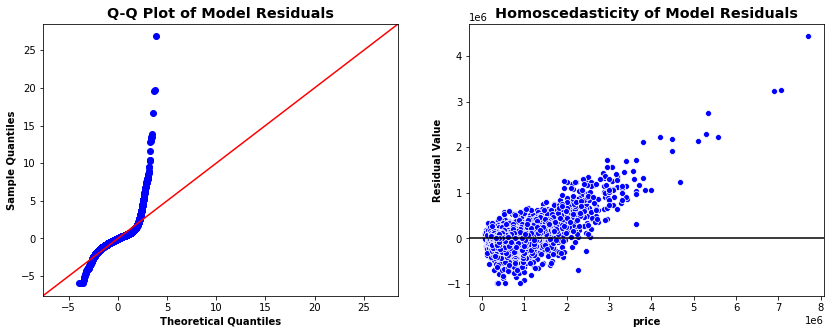

In [392]:
check_ols_assumptions(init_model, data, 'price')

> - The model residuals are definitely extremely non-normally distributed, but this isn't surprising given that no outliers have been removed. Additionally none of the variables have been transformed to be more normally distributed and multicollinearity has not been addressed.
- The residuals also clearly violate the assumption of homoscedasticity. There is a clear trend that the model tends to consistently overestimate the price of less expensive houses and underestimate the price of more expensive houses.

In [393]:
find_nonsig_features(init_model)

C(condition)[T.2]     0.074
C(condition)[T.3]     0.150
C(zipcode)[T.98002]   0.055
C(zipcode)[T.98003]   0.221
C(zipcode)[T.98011]   0.304
C(zipcode)[T.98014]   0.083
C(zipcode)[T.98019]   0.675
C(zipcode)[T.98028]   0.225
C(zipcode)[T.98030]   0.447
C(zipcode)[T.98031]   0.547
C(zipcode)[T.98032]   0.734
C(zipcode)[T.98038]   0.221
C(zipcode)[T.98042]   0.407
C(zipcode)[T.98055]   0.230
C(zipcode)[T.98058]   0.756
C(zipcode)[T.98070]   0.728
C(zipcode)[T.98072]   0.052
C(zipcode)[T.98077]   0.553
C(zipcode)[T.98148]   0.094
C(zipcode)[T.98178]   0.245
C(zipcode)[T.98188]   0.395
C(zipcode)[T.98198]   0.572
dtype: float64

> - A substantial number of the condition and zipcode categories are not useful as predictors, so these categories will be dropped from the next model. 

### Initial Model 2 - Drop Condition and Zipcode

The model below is an initial model very similar to the one above, except that the nonsignificant predictors condition and zipcode have been dropped. No outliers have been removed except the house entered as having 33 bedrooms. This was adjusted to have the mean / mode of that column which was 3 bedrooms. For houses that sold more than once during the time period the data were collected, only the most recent sale is retained in the dataset so as not to violate the assumption of independence of observations. None of the variables have been transformed or scaled. 

In [394]:
target = 'price'
numerical = ['sqft_living', 'sqft_basement',
             'age', 'diff_sqft_living15', 'lat', 
             'bedrooms', 'bathrooms', 'floors', 'grade']
categorical = ['waterfront', 'renovated']

init_model2 = build_model(target, numerical, categorical, data)
init_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     4203.
Date:                Fri, 28 Aug 2020   Prob (F-statistic):               0.00
Time:                        18:09:22   Log-Likelihood:            -2.9256e+05
No. Observations:               21420   AIC:                         5.851e+05
Df Residuals:                   21408   BIC:                         5.852e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -2.634e+07   5.06e+05    -52.072      0.000   -2.73e+07   -2.53e+07
C(waterfront)[T.1]  7.812e+05   1.74e+04     44.847      0.000    7.47e+05    8.15e+05
C(renovated)[T.1]   3.268e+04   8076.507      4.046      0.000    1.68e+04    4.85e+04
sqft_living          199.6232      3.762     53.063      0.000     192.249     206.997
sqft_basement          1.3150      4.290      0.307      0.759      -7.094       9.724
age                 3253.6715     65.546     49.639      0.000    3125.196    3382.147
diff_sqft_living15   -28.6856      3.419     -8.389      0.000     -35.388     -21.983
lat                 5.364e+05   1.07e+04     50.126      0.000    5.15e+05    5.57e+05
bedrooms               -4e+04   2026.136    -19.744      0.000    -4.4e+04    -3.6e+04
bathrooms            5.02e+04   3362.860     14.929      0.000    4.36e+04    5.68e+04
floors              8228.8348   3623.938      2.271      0.023    1125.645    1.53e+04
grade               1.073e+05   2189.897     48.975      0.000    1.03e+05    1.12e+05
==============================================================================
Omnibus:                    18099.209   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1668274.539
Skew:                           3.561   Prob(JB):                         0.00
Kurtosis:                      45.644   Cond. No.                     8.30e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.3e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

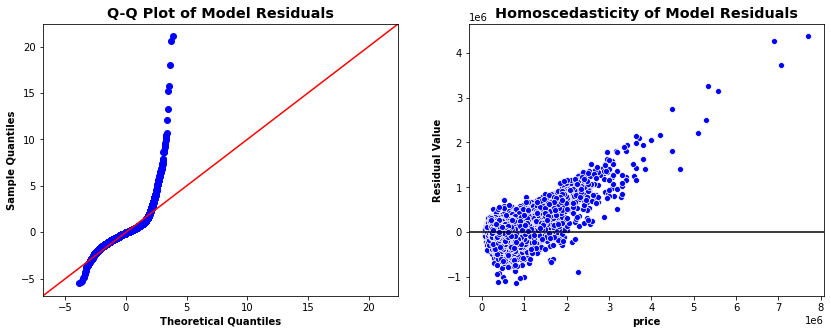

In [395]:
check_ols_assumptions(init_model2, data, 'price')

In [396]:
find_nonsig_features(init_model2)

sqft_basement   0.759
dtype: float64

### Initial Model 3 - Drop Sqft_basement

In [397]:
target = 'price'
numerical = ['sqft_living',
             'age', 'diff_sqft_living15', 'lat', 
             'bedrooms', 'bathrooms', 'floors', 'grade']
categorical = ['waterfront', 'renovated']

init_model3 = build_model(target, numerical, categorical, data)
init_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     4623.
Date:                Fri, 28 Aug 2020   Prob (F-statistic):               0.00
Time:                        18:09:46   Log-Likelihood:            -2.9256e+05
No. Observations:               21420   AIC:                         5.851e+05
Df Residuals:                   21409   BIC:                         5.852e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -2.636e+07   5.02e+05    -52.504      0.000   -2.73e+07   -2.54e+07
C(waterfront)[T.1]  7.814e+05   1.74e+04     44.899      0.000    7.47e+05    8.16e+05
C(renovated)[T.1]   3.266e+04   8076.148      4.044      0.000    1.68e+04    4.85e+04
sqft_living          199.8789      3.668     54.489      0.000     192.689     207.069
age                 3256.0351     65.090     50.024      0.000    3128.454    3383.616
diff_sqft_living15   -28.4941      3.362     -8.476      0.000     -35.083     -21.905
lat                 5.368e+05   1.06e+04     50.562      0.000    5.16e+05    5.58e+05
bedrooms               -4e+04   2026.080    -19.744      0.000    -4.4e+04    -3.6e+04
bathrooms           5.039e+04   3309.510     15.225      0.000    4.39e+04    5.69e+04
floors              7753.1231   3274.713      2.368      0.018    1334.441    1.42e+04
grade               1.072e+05   2179.629     49.176      0.000    1.03e+05    1.11e+05
==============================================================================
Omnibus:                    18093.407   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1665661.088
Skew:                           3.559   Prob(JB):                         0.00
Kurtosis:                      45.610   Cond. No.                     8.14e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.14e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

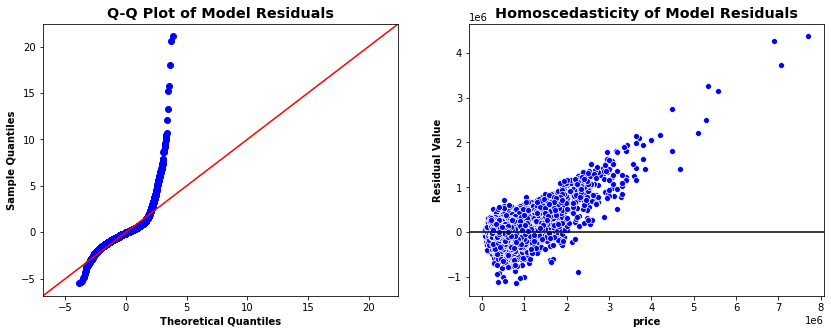

In [398]:
check_ols_assumptions(init_model3, data, 'price')

In [399]:
find_nonsig_features(init_model3)

Series([], dtype: float64)

## Z-score Outliers Removed

### Z Model 1 - Retain All Variables from First Initial Model

This is the same model as the first initial model, but fit to the dataset from which z-score outliers have been dropped. Model performance in terms of R-squared increased slightly compared to that model (increased to 0.825 compared to 0.798. The normality and homoscedasticity of model residuals also improved substantially over the initial model, but those assumptions still appear to have been violated. Condition and zipcode should still be dropped from the model.

In [401]:
target = 'price'
numerical = ['sqft_living', 'sqft_basement',
             'age', 'diff_sqft_living15', 'lat', 
             'bedrooms', 'bathrooms', 'floors', 'grade']
categorical = ['waterfront', 'condition', 'renovated', 'zipcode']

z_model = build_model(target, numerical, categorical, data_z)
z_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     1176.
Date:                Fri, 28 Aug 2020   Prob (F-statistic):               0.00
Time:                        18:10:35   Log-Likelihood:            -2.7346e+05
No. Observations:               21016   AIC:                         5.471e+05
Df Residuals:                   20931   BIC:                         5.478e+05
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -6.397e+06   2.05e+06     -3.124      0.002   -1.04e+07   -2.38e+06
C(waterfront)[T.1]   3.959e+05   1.26e+04     31.403      0.000    3.71e+05    4.21e+05
C(condition)[T.2]    4.111e+04   2.23e+04      1.843      0.065   -2610.057    8.48e+04
C(condition)[T.3]    4.648e+04   2.07e+04      2.249      0.025    5964.332     8.7e+04
C(condition)[T.4]    6.651e+04   2.07e+04      3.217      0.001     2.6e+04    1.07e+05
C(condition)[T.5]    1.033e+05   2.08e+04      4.968      0.000    6.26e+04    1.44e+05
C(renovated)[T.1]    4.139e+04   4481.808      9.235      0.000    3.26e+04    5.02e+04
C(zipcode)[T.98002]  1.724e+04   9664.839      1.783      0.075   -1707.952    3.62e+04
C(zipcode)[T.98003] -1.106e+04   8715.531     -1.269      0.204   -2.81e+04    6020.460
C(zipcode)[T.98004]  5.539e+05   1.61e+04     34.371      0.000    5.22e+05    5.85e+05
C(zipcode)[T.98005]  2.618e+05   1.66e+04     15.725      0.000    2.29e+05    2.94e+05
C(zipcode)[T.98006]  2.358e+05   1.33e+04     17.731      0.000     2.1e+05    2.62e+05
C(zipcode)[T.98007]  2.032e+05    1.7e+04     11.943      0.000     1.7e+05    2.37e+05
C(zipcode)[T.98008]  2.076e+05   1.58e+04     13.119      0.000    1.77e+05    2.39e+05
C(zipcode)[T.98010]  8.161e+04   1.24e+04      6.585      0.000    5.73e+04    1.06e+05
C(zipcode)[T.98011]  6.674e+04   2.16e+04      3.092      0.002    2.44e+04    1.09e+05
C(zipcode)[T.98014]  8.476e+04   1.94e+04      4.367      0.000    4.67e+04    1.23e+05
C(zipcode)[T.98019]  4.146e+04   2.09e+04      1.981      0.048     428.757    8.25e+04
C(zipcode)[T.98022]  3.833e+04   1.01e+04      3.798      0.000    1.85e+04    5.81e+04
C(zipcode)[T.98023] -3.236e+04   7557.788     -4.281      0.000   -4.72e+04   -1.75e+04
C(zipcode)[T.98024]  1.419e+05   1.75e+04      8.122      0.000    1.08e+05    1.76e+05
C(zipcode)[T.98027]  1.484e+05   1.21e+04     12.229      0.000    1.25e+05    1.72e+05
C(zipcode)[T.98028]  6.775e+04   2.11e+04      3.204      0.001    2.63e+04    1.09e+05
C(zipcode)[T.98029]  1.776e+05   1.37e+04     12.927      0.000    1.51e+05    2.05e+05
C(zipcode)[T.98030] -7719.5591   9290.398     -0.831      0.406   -2.59e+04    1.05e+04
C(zipcode)[T.98031] -6660.6438   9666.594     -0.689      0.491   -2.56e+04    1.23e+04
C(zipcode)[T.98032] -1.146e+04   1.17e+04     -0.979      0.328   -3.44e+04    1.15e+04
C(zipcode)[T.98033]  2.973e+05   1.79e+04     16.614      0.000    2.62e+05    3.32e+05
C(zipcode)[T.98034]  1.375e+05   1.93e+04      7.123      0.000    9.96e+04    1.75e+05
C(zipcode)[T.98038]   2.57e+04   7784.389      3.302      0.001    1.04e+04     4.1e+04
C(zipcode)[T.98039]  7.433e+05   3.03e+04     24.534      0.000    6.84e+05    8.03e+05
C(zipcode)[T.98040]  4.347e+05   1.42e+04     30.529      0.000    4.07e+05    4.63e+05
C(z

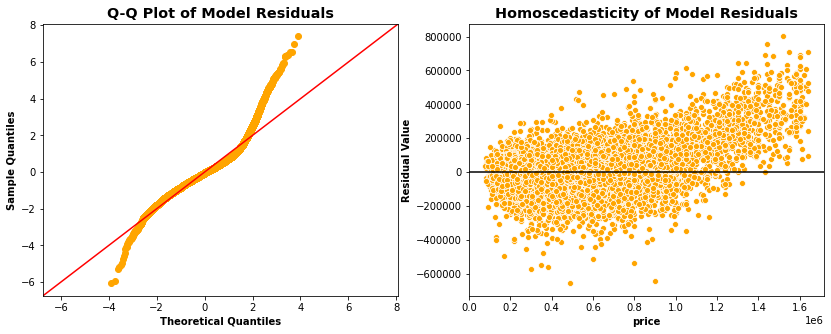

In [402]:
check_ols_assumptions(z_model, data_z, 'price')

> - The model residuals now appear much more homoscedastic than for the initial model before the removal of any outliers. There is a trend that errors tend to increase in the positive direction for more expensive houses, so there is still some heteroscedasticity.
- While the residuals appear much more normally distributed than in the initial model, the assumption of normality still does not appear to have been met. This is not surprising, especially given that multicollinearity is likely to be an issue in this model.

In [403]:
find_nonsig_features(z_model)

C(condition)[T.2]     0.065
C(zipcode)[T.98002]   0.075
C(zipcode)[T.98003]   0.204
C(zipcode)[T.98030]   0.406
C(zipcode)[T.98031]   0.491
C(zipcode)[T.98032]   0.328
C(zipcode)[T.98042]   0.601
C(zipcode)[T.98058]   0.349
C(zipcode)[T.98188]   0.134
dtype: float64

> - This is consistent with the results of the first initial model, indicating that condition and zipcode should be dropped as predictors.

### Z Model 2 - Drop Condition and Zipcode

In [404]:
target = 'price'
numerical = ['sqft_living', 'sqft_basement',
             'age', 'diff_sqft_living15', 'lat', 
             'bedrooms', 'bathrooms', 'floors', 'grade']
categorical = ['waterfront', 'renovated']

z_model2 = build_model(target, numerical, categorical, data_z)
z_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     4354.
Date:                Fri, 28 Aug 2020   Prob (F-statistic):               0.00
Time:                        18:10:48   Log-Likelihood:            -2.7930e+05
No. Observations:               21016   AIC:                         5.586e+05
Df Residuals:                   21004   BIC:                         5.587e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -2.537e+07   3.51e+05    -72.246      0.000   -2.61e+07   -2.47e+07
C(waterfront)[T.1]  3.412e+05   1.61e+04     21.138      0.000     3.1e+05    3.73e+05
C(renovated)[T.1]   2.569e+04   5782.534      4.442      0.000    1.44e+04     3.7e+04
sqft_living          142.6128      2.692     52.971      0.000     137.336     147.890
sqft_basement         19.1713      3.095      6.194      0.000      13.105      25.238
age                 2611.2991     46.573     56.069      0.000    2520.012    2702.586
diff_sqft_living15   -55.6550      2.493    -22.321      0.000     -60.542     -50.768
lat                 5.193e+05   7431.618     69.882      0.000    5.05e+05    5.34e+05
bedrooms           -1.668e+04   1437.293    -11.608      0.000   -1.95e+04   -1.39e+04
bathrooms           3.444e+04   2385.438     14.437      0.000    2.98e+04    3.91e+04
floors              2.938e+04   2560.782     11.471      0.000    2.44e+04    3.44e+04
grade               9.376e+04   1550.683     60.466      0.000    9.07e+04    9.68e+04
==============================================================================
Omnibus:                     4952.020   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18331.496
Skew:                           1.148   Prob(JB):                         0.00
Kurtosis:                       6.958   Cond. No.                     7.95e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.95e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

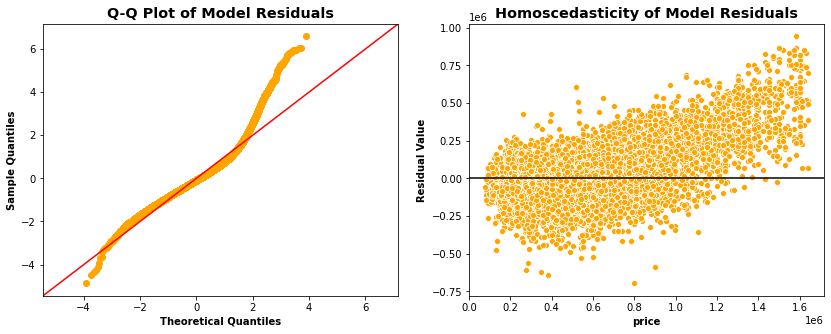

In [405]:
check_ols_assumptions(z_model2, data_z, 'price')

In [406]:
find_nonsig_features(z_model2)

Series([], dtype: float64)

## IQR Outliers Removed

### IQR Model 1 - Retain All Variables from First Initial Model

In [407]:
target = 'price'
numerical = ['sqft_living', 'sqft_basement',
             'age', 'diff_sqft_living15', 'lat', 
             'bedrooms', 'bathrooms', 'floors', 'grade']
categorical = ['waterfront', 'condition', 'renovated', 'zipcode']

IQR_model = build_model(target, numerical, categorical, data_IQR)
IQR_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     1123.
Date:                Fri, 28 Aug 2020   Prob (F-statistic):               0.00
Time:                        18:11:07   Log-Likelihood:            -2.5930e+05
No. Observations:               20268   AIC:                         5.188e+05
Df Residuals:                   20183   BIC:                         5.194e+05
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -6.822e+06   1.67e+06     -4.076      0.000   -1.01e+07   -3.54e+06
C(waterfront)[T.1]   2.551e+05   1.27e+04     20.048      0.000     2.3e+05     2.8e+05
C(condition)[T.2]    5.579e+04   1.82e+04      3.061      0.002    2.01e+04    9.15e+04
C(condition)[T.3]    7.412e+04   1.69e+04      4.379      0.000    4.09e+04    1.07e+05
C(condition)[T.4]    9.353e+04   1.69e+04      5.524      0.000    6.03e+04    1.27e+05
C(condition)[T.5]    1.261e+05    1.7e+04      7.403      0.000    9.27e+04     1.6e+05
C(renovated)[T.1]    3.522e+04   3773.309      9.333      0.000    2.78e+04    4.26e+04
C(zipcode)[T.98002]  6600.3601   7770.434      0.849      0.396   -8630.324    2.18e+04
C(zipcode)[T.98003] -6244.8415   7005.877     -0.891      0.373      -2e+04    7487.248
C(zipcode)[T.98004]  4.521e+05   1.37e+04     33.104      0.000    4.25e+05    4.79e+05
C(zipcode)[T.98005]   2.71e+05   1.36e+04     19.906      0.000    2.44e+05    2.98e+05
C(zipcode)[T.98006]  2.298e+05   1.09e+04     21.017      0.000    2.08e+05    2.51e+05
C(zipcode)[T.98007]  2.051e+05   1.39e+04     14.804      0.000    1.78e+05    2.32e+05
C(zipcode)[T.98008]  1.978e+05   1.29e+04     15.311      0.000    1.72e+05    2.23e+05
C(zipcode)[T.98010]  8.846e+04   9963.785      8.878      0.000    6.89e+04    1.08e+05
C(zipcode)[T.98011]  7.451e+04   1.76e+04      4.236      0.000       4e+04    1.09e+05
C(zipcode)[T.98014]  8.003e+04   1.58e+04      5.057      0.000     4.9e+04    1.11e+05
C(zipcode)[T.98019]  4.322e+04   1.71e+04      2.535      0.011    9797.752    7.67e+04
C(zipcode)[T.98022]  4.044e+04   8136.178      4.971      0.000    2.45e+04    5.64e+04
C(zipcode)[T.98023] -2.678e+04   6081.059     -4.405      0.000   -3.87e+04   -1.49e+04
C(zipcode)[T.98024]  1.329e+05   1.43e+04      9.303      0.000    1.05e+05    1.61e+05
C(zipcode)[T.98027]  1.563e+05   9860.209     15.855      0.000    1.37e+05    1.76e+05
C(zipcode)[T.98028]  6.831e+04   1.72e+04      3.961      0.000    3.45e+04    1.02e+05
C(zipcode)[T.98029]  1.869e+05   1.12e+04     16.725      0.000    1.65e+05    2.09e+05
C(zipcode)[T.98030] -6678.9830   7477.205     -0.893      0.372   -2.13e+04    7976.949
C(zipcode)[T.98031] -6512.8169   7793.945     -0.836      0.403   -2.18e+04    8763.951
C(zipcode)[T.98032] -1.552e+04   9422.443     -1.647      0.100    -3.4e+04    2953.706
C(zipcode)[T.98033]   2.65e+05   1.47e+04     18.060      0.000    2.36e+05    2.94e+05
C(zipcode)[T.98034]  1.268e+05   1.58e+04      8.044      0.000    9.59e+04    1.58e+05
C(zipcode)[T.98038]    2.9e+04   6273.920      4.622      0.000    1.67e+04    4.13e+04
C(zipcode)[T.98039]  5.776e+05   4.09e+04     14.109      0.000    4.97e+05    6.58e+05
C(zipcode)[T.98040]  3.667e+05   1.22e+04     30.057      0.000    3.43e+05    3.91e+05
C(z

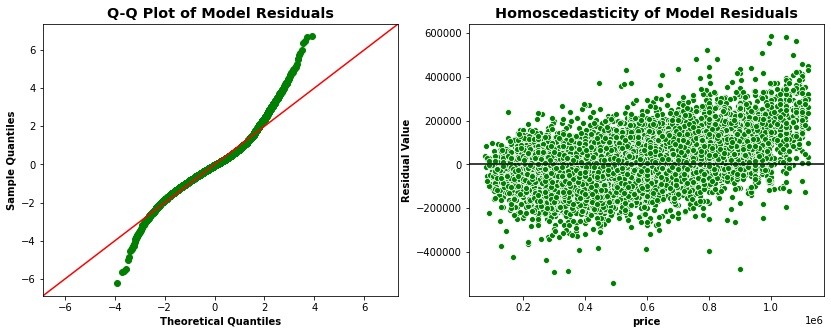

In [408]:
check_ols_assumptions(IQR_model, data_IQR, 'price')

> - The trends seen here are very similar to those observed for the same model fitted to the z-score cleaned data. 
- The model residuals now appear much more homoscedastic than for the initial model before the removal of any outliers. There is a trend that errors tend to increase in the positive direction for more expensive houses, so there is still some heteroscedasticity. However the degree of heteroscedasticity seems lower than that of the z-score model.
- While the residuals appear much more normally distributed than in the initial model, the assumption of normality still does not appear to have been met. This is not surprising, especially given that multicollinearity is likely to be an issue in this model.

In [409]:
find_nonsig_features(IQR_model)

C(zipcode)[T.98002]   0.396
C(zipcode)[T.98003]   0.373
C(zipcode)[T.98030]   0.372
C(zipcode)[T.98031]   0.403
C(zipcode)[T.98032]   0.100
C(zipcode)[T.98042]   0.783
C(zipcode)[T.98058]   0.083
C(zipcode)[T.98188]   0.163
dtype: float64

> - This model indicates that zipcode is the only variable that may not be a good predictor. Condition actually remains as a significant predictor for this model fit to the IQR cleaned data.

### IQR Model 2 - Drop Zipcode

In [410]:
target = 'price'
numerical = ['sqft_living', 'sqft_basement',
             'age', 'diff_sqft_living15', 'lat', 
             'bedrooms', 'bathrooms', 'floors', 'grade']
categorical = ['waterfront', 'condition', 'renovated']

IQR_model2 = build_model(target, numerical, categorical, data_IQR)
IQR_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     2973.
Date:                Fri, 28 Aug 2020   Prob (F-statistic):               0.00
Time:                        18:11:35   Log-Likelihood:            -2.6510e+05
No. Observations:               20268   AIC:                         5.302e+05
Df Residuals:                   20252   BIC:                         5.304e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -2.51e+07   2.89e+05    -86.865      0.000   -2.57e+07   -2.45e+07
C(waterfront)[T.1]  2.296e+05   1.63e+04     14.058      0.000    1.98e+05    2.62e+05
C(condition)[T.2]   3.545e+04   2.42e+04      1.467      0.142   -1.19e+04    8.28e+04
C(condition)[T.3]   5.393e+04   2.24e+04      2.403      0.016    9931.197    9.79e+04
C(condition)[T.4]   8.045e+04   2.24e+04      3.584      0.000    3.64e+04    1.24e+05
C(condition)[T.5]   1.121e+05   2.26e+04      4.965      0.000    6.79e+04    1.56e+05
C(renovated)[T.1]   3.181e+04   4975.690      6.394      0.000    2.21e+04    4.16e+04
sqft_living          127.3464      2.289     55.628      0.000     122.859     131.834
sqft_basement          7.4191      2.656      2.794      0.005       2.214      12.624
age                 1901.8586     41.451     45.882      0.000    1820.611    1983.106
diff_sqft_living15   -55.2332      2.151    -25.673      0.000     -59.450     -51.016
lat                 5.163e+05   6096.015     84.691      0.000    5.04e+05    5.28e+05
bedrooms           -1.221e+04   1201.938    -10.157      0.000   -1.46e+04   -9852.059
bathrooms           2.566e+04   2002.344     12.815      0.000    2.17e+04    2.96e+04
floors              3.214e+04   2149.697     14.951      0.000    2.79e+04    3.64e+04
grade               7.465e+04   1310.554     56.963      0.000    7.21e+04    7.72e+04
==============================================================================
Omnibus:                     1873.956   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3361.319
Skew:                           0.649   Prob(JB):                         0.00
Kurtosis:                       4.516   Cond. No.                     7.64e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

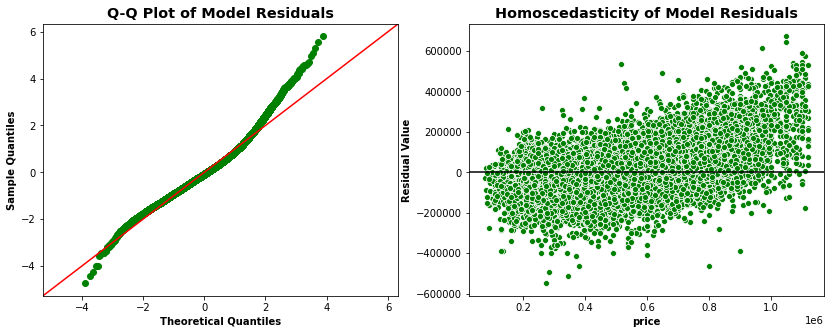

In [411]:
check_ols_assumptions(IQR_model2, data_IQR, 'price')

In [412]:
find_nonsig_features(IQR_model2)

C(condition)[T.2]   0.142
dtype: float64

### IQR Model 3 - Drop Zipcode and Condition

In [413]:
target = 'price'
numerical = ['sqft_living', 'sqft_basement',
             'age', 'diff_sqft_living15', 'lat', 
             'bedrooms', 'bathrooms', 'floors', 'grade']
categorical = ['waterfront', 'renovated']

IQR_model3 = build_model(target, numerical, categorical, data_IQR)
IQR_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     3940.
Date:                Fri, 28 Aug 2020   Prob (F-statistic):               0.00
Time:                        18:11:57   Log-Likelihood:            -2.6530e+05
No. Observations:               20268   AIC:                         5.306e+05
Df Residuals:                   20256   BIC:                         5.307e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -2.459e+07   2.89e+05    -85.027      0.000   -2.52e+07    -2.4e+07
C(waterfront)[T.1]  2.301e+05   1.65e+04     13.955      0.000    1.98e+05    2.62e+05
C(renovated)[T.1]   1.751e+04   4963.435      3.528      0.000    7779.995    2.72e+04
sqft_living          125.7810      2.308     54.496      0.000     121.257     130.305
sqft_basement         10.5044      2.677      3.924      0.000       5.258      15.751
age                 2140.9893     39.768     53.837      0.000    2063.040    2218.938
diff_sqft_living15   -53.9223      2.169    -24.856      0.000     -58.175     -49.670
lat                 5.068e+05   6121.939     82.776      0.000    4.95e+05    5.19e+05
bedrooms           -1.144e+04   1212.389     -9.432      0.000   -1.38e+04   -9058.874
bathrooms           2.864e+04   2012.651     14.228      0.000    2.47e+04    3.26e+04
floors              2.824e+04   2154.385     13.106      0.000     2.4e+04    3.25e+04
grade               7.498e+04   1320.559     56.782      0.000    7.24e+04    7.76e+04
==============================================================================
Omnibus:                     1813.568   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3243.628
Skew:                           0.633   Prob(JB):                         0.00
Kurtosis:                       4.496   Cond. No.                     7.58e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.58e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

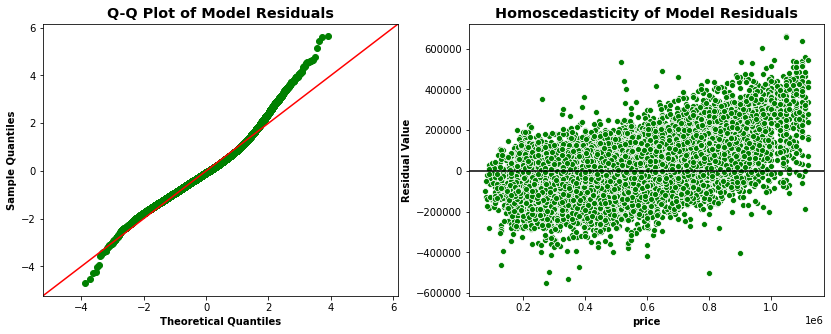

In [414]:
check_ols_assumptions(IQR_model3, data_IQR, 'price')

# INTERPRET

# Conclusions/ Recommendations